# ChIP AML PiPeline v2

In [234]:
import os
import pandas as pd

import itertools
from scipy import stats
import numpy as np

from genepy.epigenetics import chipseq as chip
from genepy.utils import helper, plot
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv
from collections import Counter

from scipy.special import factorial
from scipy.stats import fisher_exact

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_double"
window="150"

In [141]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t')

In [151]:
#%store -r merged
#%store -r chrombed
#%store -r mergedpeak
#%store -r cols
#%store -r annot
#%store -r version
#%store -r merging_version
#%store -r window
#%store -r crc

In [7]:
cols=8
annot=37

In [52]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.txt')

## Doing Motif analysis

In [ ]:
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta ../../data/ref
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict ../../data/ref

In [ ]:
gatk='java -jar ~/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar'

In [ ]:
#snps
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz ../temp/input_snp.vcf.gz
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz.tbi ../temp/input_snp.vcf.gz.tbi

In [ ]:
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast
! mkdir ../../data/$project/MEME_$version/
! cp ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed && $gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O ../temp/middle.fasta -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed -V ../temp/input_snp.vcf.gz && fold ../temp/middle.fasta -w 500 > ../../data/$project/MEME_$version/ATAC.fasta

cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && fimo --oc ../../data/"+project+"/MEME_"+version+"/ATAC/ ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme ../../data/"+project+"/MEME_"+version+"/ATAC.fasta"
! $cmd

! gff2bed < ../../data/$project/MEME_$version/ATAC/fimo.gff > ../../data/$project/MEME_$version/ATAC/fimo.gff.bed

In [ ]:
merged_motif = pd.read_csv('../../data/MEME/merged/fimo.gff.bed', sep='\t',skiprows=0,index_col=None, names=['pos', 'relstart', 'relend', "name", "strength","strand",'fimo','nucleotide_motif',".","data"])

merged_motif['tf'] = [i.split('_HUMAN')[0] for i in merged_motif.name]
merged_motif.relstart = merged_motif.relstart.astype(int)
merged_motif['start'] = [i.split(':')[1].split('-')[0] for i in merged_motif.pos]
merged_motif.start = merged_motif.start.astype(int)
merged_motif.relend = merged_motif.relend.astype(int)
merged_motif.start = merged_motif.start+merged_motif.relstart
merged_motif['end'] = merged_motif.start+merged_motif.relend
merged_motif['chrom'] = [i.split(':')[0][3:] for i in merged_motif.pos]


In [93]:
rn={'HOXA9':'HXA9',
 'SREBF1':'SRBP1',
 'STAT5B':'STA5B',
 'ZEB2':"ZEB1",
 'ZNF281':'ZN281'}
proteins = []
for i in merged.columns[cols:]:
    for k,v in rn.items():
        i = i.replace(k,v)
    proteins.append(i)
set(proteins) - set(merged_motif.tf)

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'LDB1',
 'LMO2',
 'MED1',
 'MLL_KTM2A',
 'MYBL2',
 'PLAGL2',
 'POLII',
 'PSER2',
 'SMC1',
 'WDR5',
 'ZMYND8',
 'activation',
 'repression',
 'super_enhancer'}

In [94]:
merged_motif = merged_motif[merged_motif.tf.isin(proteins)]
merged_motif['pval'] = [float(i.split('pvalue=')[1].split(';')[0]) for i in merged_motif.data]
merged_motif['seq'] = [i.split('sequence=')[1].split(';')[0] for i in merged_motif.data]
merged_motif = merged_motif[['chrom', 'start', 'end', "strength", 'pval','strand', 'tf','seq']].sort_values(by=['chrom','start','strength']).reset_index(drop = True)
merged_motif = merged_motif.rename(columns={'chr':'chrom'})
merged_motif.chrom = "chr"+merged_motif.chrom
merged_motif.chrom = merged_motif.chrom.astype(str)

<ipython-input-94-fa174bf48da8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_motif['pval'] = [float(i.split('pvalue=')[1].split(';')[0]) for i in merged_motif.data]
<ipython-input-94-fa174bf48da8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_motif['seq'] = [i.split('sequence=')[1].split(';')[0] for i in merged_motif.data]


KeyError: "['end'] not in index"

In [97]:
a = {}
for k,v in rn.items():
    a[v] = k 
rn = a
merged_motif['tf'] = merged_motif['tf'].replace(rn)

In [98]:
merged_motif = merged_motif.rename(columns={'strength':"foldchange"})

In [99]:
merged_motif

,chrom,start,end,foldchange,pval,strand,tf,seq
0,chr1,10282,10707,40.5,0.000090,-,RUNX2,GGGTTGGGGTTAGG
1,chr1,10288,10719,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
2,chr1,10294,10731,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
3,chr1,10300,10743,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
4,chr1,10306,10755,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
...,...,...,...,...,...,...,...,...
2241485,chrY,56876566,56876635,56.1,0.000002,-,SPI1,GGATAGCGGAAGTGAAA
2241486,chrY,56876568,56876635,52.9,0.000005,-,ELF2,ATAGCGGAAGTGA
2241487,chrY,56876668,56876833,46.0,0.000025,-,MYC,GCCATGTGTTT
2241488,chrY,56878627,56878678,45.3,0.000030,+,GATA2,AAAGATAAGAG


In [22]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [100]:
merged_motif.to_csv('../results/'+project+'/large/'+version+'_merged_motif.bed.gz', sep='\t')

In [54]:
merged_motif = pd.read_csv('../results/'+project+'/large/'+version+'_merged_motif.bed.gz', sep='\t')

In [26]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t')

## what motifs map to their right binding event

In [71]:
set(merged.columns)

{'-log10pvalue',
 '-log10qvalue',
 'AFF4',
 'ATAC',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPA_mot',
 'CEBPB',
 'CEBPB_mot',
 'CTCF',
 'CTCF_mot',
 'E2F3',
 'E2F3_mot',
 'ELF2',
 'ELF2_mot',
 'ETV6',
 'ETV6_mot',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FLI1_mot',
 'FOSL2',
 'FOSL2_mot',
 'FOXP1',
 'FOXP1_mot',
 'GATA2',
 'GATA2_mot',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'HOXA9_mot',
 'IKZF1',
 'IKZF1_mot',
 'IRF8',
 'IRF8_mot',
 'JUND',
 'JUND_mot',
 'LDB1',
 'LMO2',
 'LYL1',
 'LYL1_mot',
 'MAX',
 'MAX_mot',
 'MED1',
 'MEIS1',
 'MEIS1_mot',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYB_mot',
 'MYC',
 'MYC_mot',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RARA_mot',
 'RUNX1',
 'RUNX1_mot',
 'RUNX2',
 'RUNX2_mot',
 'RXRA',
 'RXRA_mot',
 'SMC1',
 'SP1',
 'SP1_mot',
 'SRBP1_mot',
 'SREBF1',
 'STAT5B',
 'STAT5B_mot',
 'TFAP4',
 'TFAP4_mot',
 'WDR5',
 'ZEB2',
 'ZEB2_mot',
 

In [27]:
for val in set(merged_motif.tf):
    merged[val+'_mot'] = chip.putInBed(merged[merged.columns[:cols]], merged_motif[merged_motif.tf==val], window=100)
merged = merged.replace(np.nan,0)

66657 were merged into conscensus
31271 were merged into conscensus
32285 were merged into conscensus
27531 were merged into conscensus
27714 were merged into conscensus
37343 were merged into conscensus
56274 were merged into conscensus
35206 were merged into conscensus
23331 were merged into conscensus
57865 were merged into conscensus
33019 were merged into conscensus
20639 were merged into conscensus
23950 were merged into conscensus
44996 were merged into conscensus
34847 were merged into conscensus
94374 were merged into conscensus
37051 were merged into conscensus
24886 were merged into conscensus
35416 were merged into conscensus
21410 were merged into conscensus
28460 were merged into conscensus
18652 were merged into conscensus
30756 were merged into conscensus
21322 were merged into conscensus
16499 were merged into conscensus
51147 were merged into conscensus
46342 were merged into conscensus
34280 were merged into conscensus
105158 were merged into conscensus
44487 were me

In [14]:
merged['FLAG_MEF2D_mot'] = merged.MEF2C_mot

In [178]:
# adding +motif -motif TF
names = merged.columns[motloc+cols:]
for val in names:
    v = val.replace('_mot','')
    name = v
    for i in merged.columns[cols:annot].tolist():
        if v in i and v!=i:
            name = 'FLAG_'+v
    merged[name+'_wmot'] = (merged[name]!=0) & (merged[v+"_mot"]!=0)

KeyboardInterrupt: 

In [39]:
merged = merged.rename(columns={"GFI1_mot":"FLAG_GFI1_mot"})

In [258]:
merging_version="remove_triple"
merged = merged[merged[merged.columns[cols:annot]].astype(bool).sum(1)>3].fillna(0).reset_index(drop=True)

In [260]:
merged.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t')

In [579]:
merging_version = "remove_single"

In [580]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t', index_col=0)

In [ ]:
merged

### computing frequency binding of a motif with its TF.

barplot of the percentage of peaks that overlap with Motifs found for the same TF. peaks are found with MACS2. We are only looking at Motifs on the regions defined by the cobinding matrix: (regions with at least 2 CRC TF cobinding).

In [215]:
a = []
b = []
for val in set(merged.columns[8:]):
    if '_mot' in val:
        b.append(val[:-4])
        a.append(merged[merged[val]!=0][val[:-4]].astype(bool).sum() / merged[val[:-4]].astype(bool).sum())
# adding MEF2D

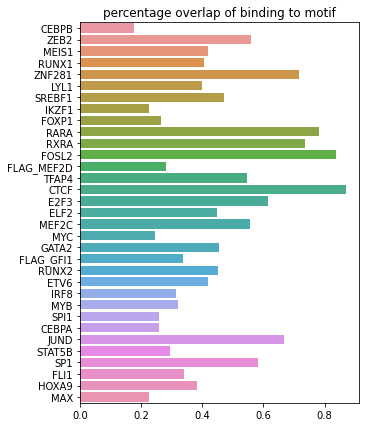

In [216]:
f, ax = plt.subplots(figsize=(5,7))
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T, orient='h', ax=ax)
plt.title("percentage overlap of binding to motif")
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/percentage_overlap_binding2motif.pdf")

In [118]:
np.mean(a)

0.46220848463486913

## Unbound Open region Motifs:

What are the motifs of our CRC members in ATACseq but not in our matrix


In [72]:
overlap = [66657, 31271, 32285, 27531, 27714, 37343, 56274, 35206, 23331, 57865, 33019, 20639, 23950, 44996, 34847, 94374, 37051, 24886, 35416, 21410, 28460, 18652, 30756, 21322, 16499, 51147, 46342, 34280, 105158, 44487, 31013, 74874, 34847]

In [56]:
merged_motif['tf'] = merged_motif.tf.replace({"SRBP1":"SREBF1","HXA9":"HOXA9"})

In [217]:
a = []
b = []
for i, val in enumerate([i[:-4] for i in merged.columns[motloc+cols:motannot+cols]]):
    b.append(val)
    a.append(overlap[i] / (merged_motif.tf==val.replace('FLAG_','').replace('MEF2D',"MEF2C")).sum())

barplot of the percentage of Motifs for a specific TF that are bound by this TF. Motifs are found with MEME on Open chromatin region. A TF is considered bound if it has a peak at that region.

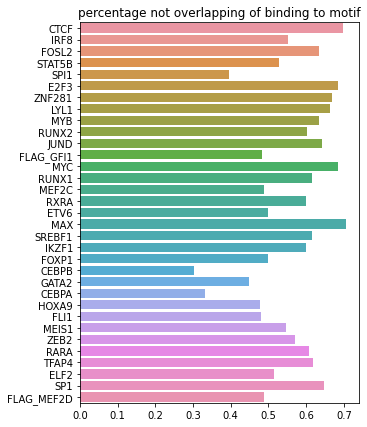

In [218]:
f, ax = plt.subplots(figsize=(5,7))
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T, orient='h', ax=ax)
plt.title("percentage not overlapping of binding to motif")
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/percentage_nonoverlap_binding2motif.pdf")

## regulatory code: 

For each TF with known motifs, we look at the set of possible sets of cobinding CRC TF. for each set we compute its enrichment. we then display the most enriched sets 

Issue: Due to the exponential complexity of computing each possible pvalues, we do not, the test is thus not BH corrected when it is on a set of $\sum_{k = 2..10} {29 \choose k}$ possible realizations: 36,519,526 and it is not chosen  randomly 

In [123]:
from scipy.special import comb
suma=0
for i in range(2,11):
    suma += comb(29,i)
int(suma)

36519526

In [32]:
#@jit(parallel=True)
#TODO: chisquare tests except when the number in contingency is below a certain value
def compfish(e, proba, size1, size2):
    folds = {}
    pvals = {}
    i=0
    for k, v in e.items():
        if len(k)<9 and v>100:
            a = np.prod(proba[list(k)])#*factorial(len(k))
            if (a / size1) * 1.2 < v / size2:
                a = int(a*size2)
                i+=1
                fold, p = fisher_exact([[size1-a,a],[size2-v,v]])
                folds[fold] = np.log2(k)
                pvals[k] = p
    print(i)
    return folds, pvals

In [ ]:
## what enrichment do we have in each group? what enrichment do we have for each ChipSeq?
res = {val: {} for i, val in enumerate([i[:-4] for i in mergedmot.columns[72:]])}
proba = mergedmot[mergedmot.columns[8:37]].astype(bool).sum()/len(mergedmot)
for i, val in enumerate([i[:-4] for i in mergedmot.columns[72:]]):
    a,b = np.where(mergedmot[(mergedmot[val]!=0)][mergedmot.columns[8:37]]!=0) #72
    e = []
    u = []
    preva=a[0]
    print('_________________')
    print(val)
    for i, v in enumerate(a):
        n = mergedmot.columns[8+b[i]]
        if n == val or n=="CEBPA":
            continue
        # we are still on the same row
        if v == preva:
            u.append(n)
            e.append(tuple(u))
        # we moved
        else:
            e.append(tuple(u))
            u = [n]
        preva = v
    e = Counter(e)
    s = len(set(a))
    d,f = compfish(dict(e), proba, len(mergedmot), s)
    #    v = (v/s)*100
    #    if v >5:
    #        d[v] = k
    a = list(d.keys())
    a.sort()
    for v in a[::-1]:
    #    print("%.2f%% for: %s" % (v, str(d[v])))
        if v>4:
            print("%.2f,%.2f for: %s" % (v, f[d[v]], str(d[v]), ))
        res[val][d[v]] = (v, f[d[v]])

In [64]:
helper.dictToFile(helper.stringifydict(res),"../results/"+project+"/"+version+"_"+window+"_cobinding_code_nomotif_filter.json")

In [238]:
for k,v in res.items():
    print('______________________')
    print(k)
    for i,j in v.items():
        a = np.log2(j[0])
        if a>4:
            print("%.2f,%.2f for: %s" % (a, j[1], str(i)))

______________________
FOXP1
4.37,0.00 for: ('HOXA9', 'MEIS1', 'RUNX1', 'FLI1')
4.33,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'GATA2')
4.28,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1')
4.26,0.00 for: ('MEIS1', 'RUNX1', 'FLI1', 'SP1', 'STAT5B', 'ZMYND8')
4.25,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'ZNF281')
4.20,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'STAT5B')
4.18,0.00 for: ('MEIS1', 'RUNX1', 'FLI1', 'LMO2', 'STAT5B', 'ZMYND8')
4.14,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'STAT5B', 'ZMYND8')
4.03,0.00 for: ('RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281')
inf,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'RUNX1', 'FOSL2', 'FLI1', 'SP1')
11.69,0.00 for: ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3')
11.35,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281')
10.24,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'RUNX1', 'FLI1', 'SP1')
10.12,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1', 'FLI1')
9.95,0.00 for: 

### computing motif enrichment for each TF

In [220]:
enr, pvals = await chip.enrichment(merged[merged.columns[:motannot+cols]])

/home/jeremie/genepy/genepy/epigenetics/chipseq.py:434: RuntimeWarning: divide by zero encountered in log2
  pvals[i, j+add] = p


In [168]:
motmergedloc = 92
motloc= 59

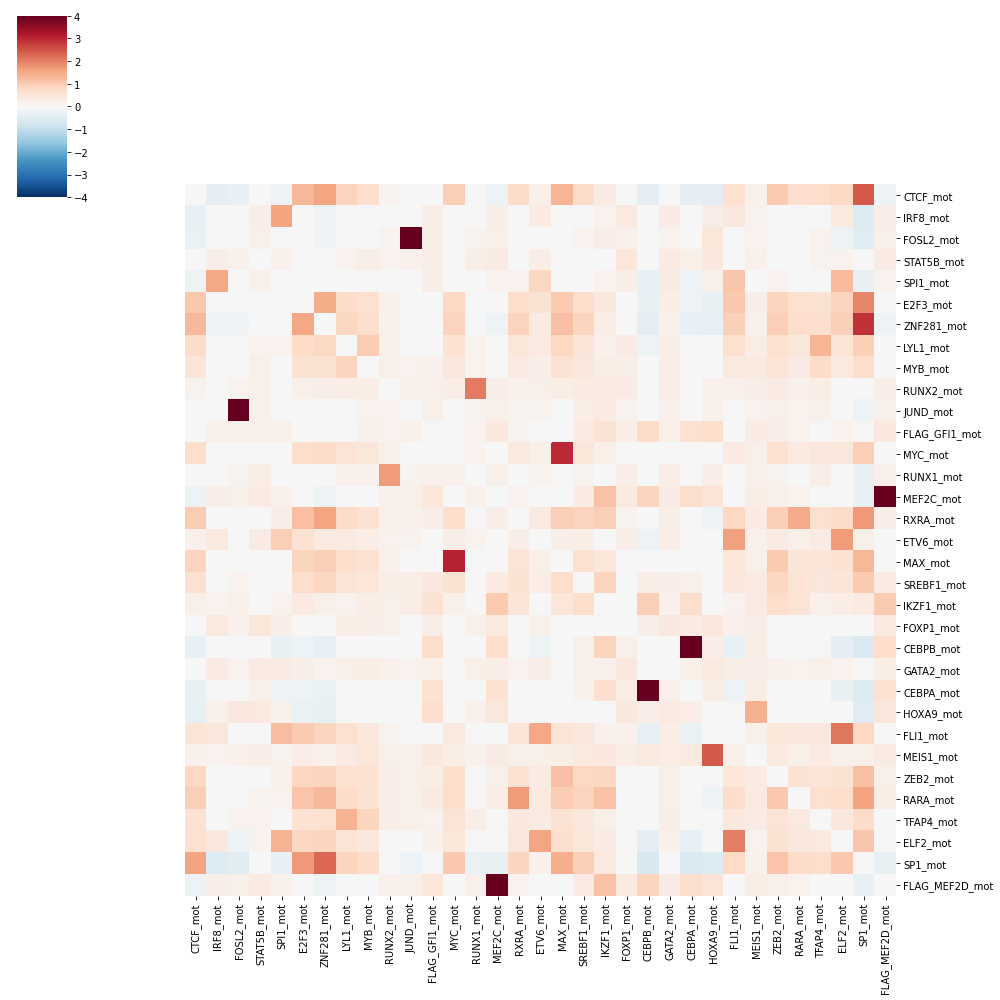

In [221]:
# enrichment for each motifs
fig = sns.clustermap(enr.iloc[motloc:motmergedloc][enr.columns[motloc:motmergedloc]],figsize=(14,14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_motifs.pdf')
plt.show()

In [201]:
len(merged[merged['CTCF']!=0]), len(merged[merged['MEF2C']!=0]), len(merged[merged['SP1']!=0]), len(merged[merged['SP1']!=0])

(16319, 11447, 24252, 24252)

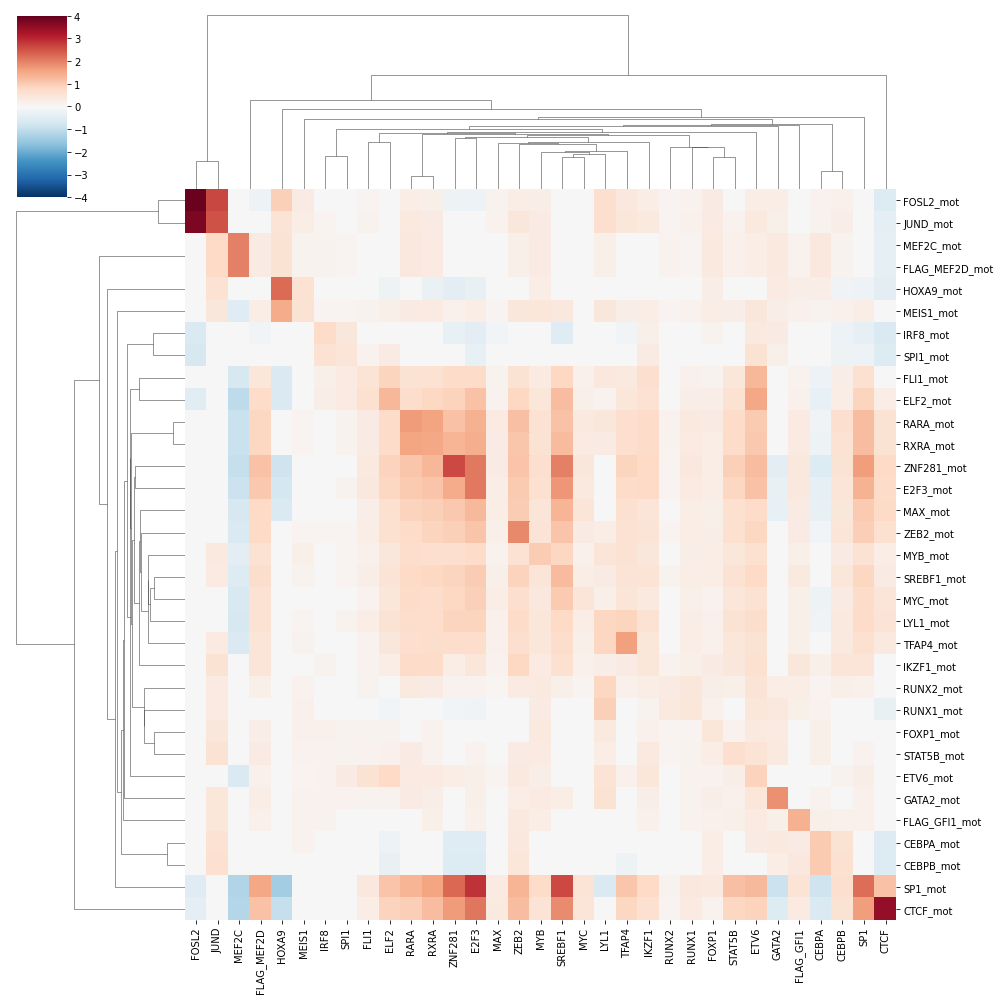

In [222]:
# enrichment for each tf signal on associated motifs
data = enr.loc[enr.columns[motloc:]][[i.split('_m')[0] for i in enr.columns[motloc:]]]
link = linkage(data, optimal_ordering=True)
fig = sns.clustermap(data, figsize=(14,14), row_linkage=link, col_linkage=link, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_crc_tfs_onmotifs.pdf')
plt.show()

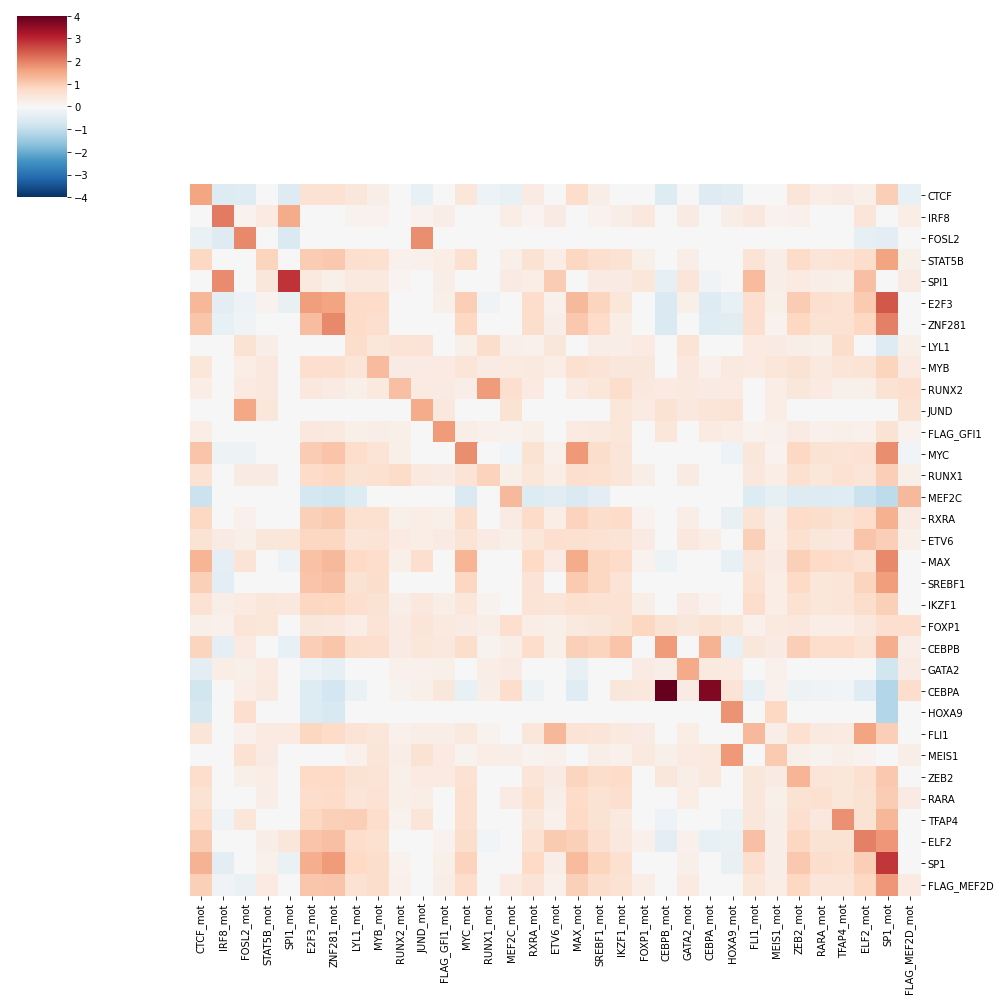

In [223]:
# enrichment for each motifs on associated tf signal
fig = sns.clustermap(enr.loc[[i.split('_m')[0] for i in enr.columns[motloc:]]][enr.columns[motloc:]], figsize=(14,14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_crc_tfs.pdf')
plt.show()

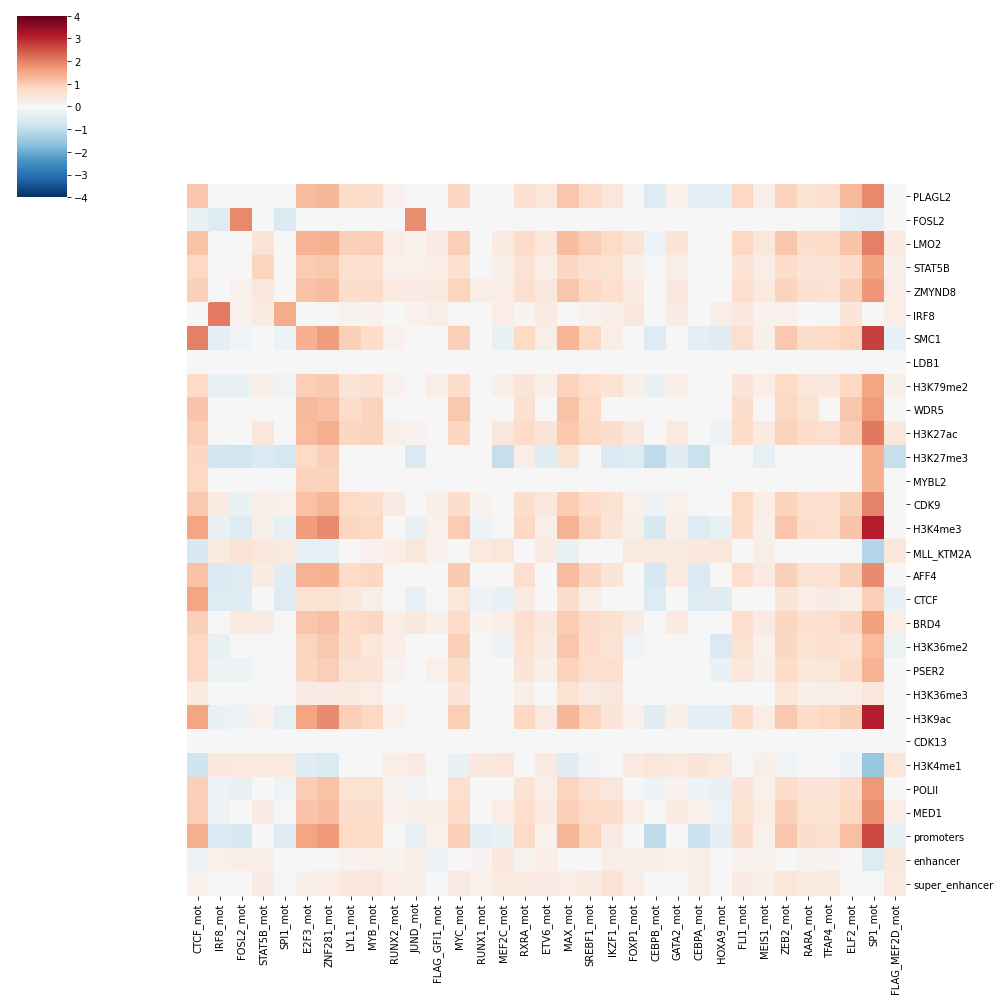

In [224]:
# enrichment on non motif peaks
fig = sns.clustermap(enr.loc[[i for i in enr.columns[:motloc] if i+'_mot' not in enr.columns[63:]]][enr.columns[motloc:]],figsize=(14, 14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_non_motif_tfs.pdf')
plt.show()

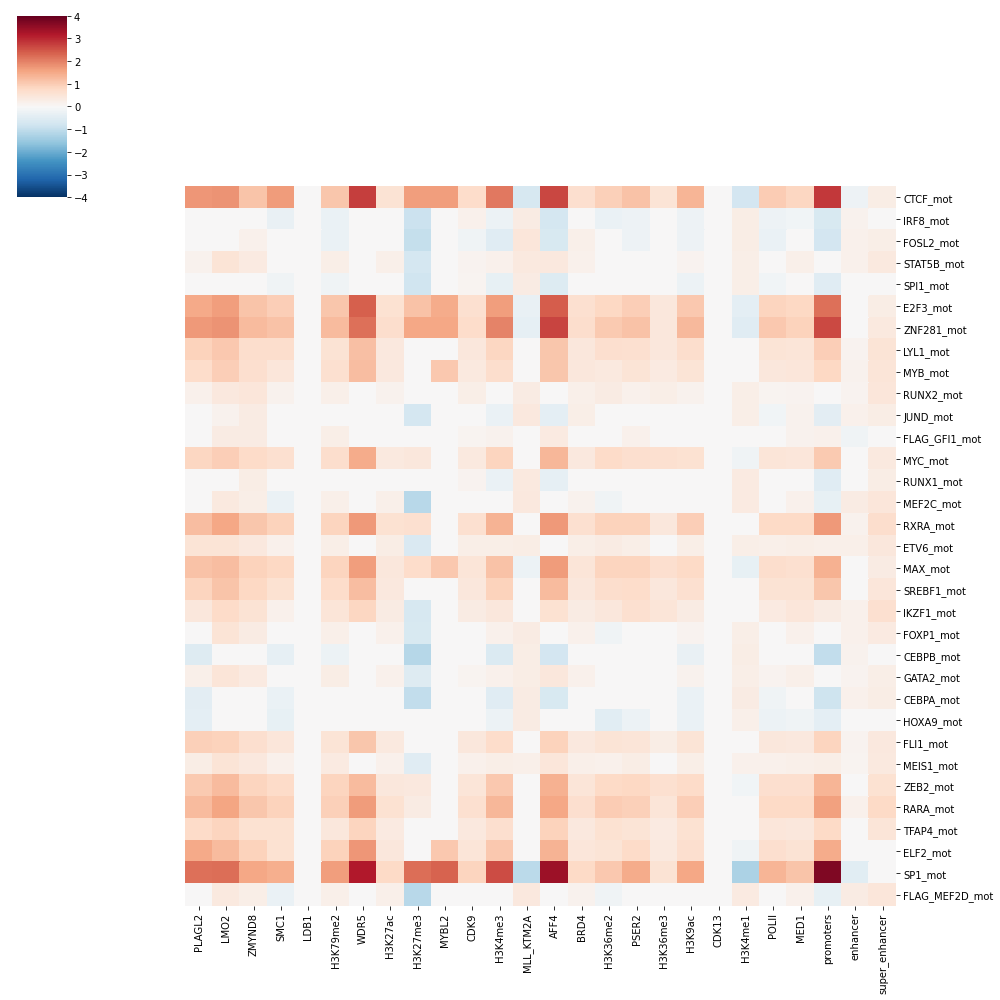

In [225]:
# enrichment on non motif peaks
data = enr.loc[enr.columns[motloc:]][[i for i in enr.columns[:motloc] if i+'_mot' not in enr.columns[motloc:]]]
fig = sns.clustermap(data,figsize=(14, 14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_of_non_motif_tfs_onmotifs.pdf')
plt.show()

### Computing motif enrichment in chip clusters

In [10]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [38]:
%store -r cols
%store -r annot

In [11]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t')

In [567]:
data= merged[merged.columns[cols:annot]].values
scaled_data = (data-data.min(0))/(data.max(0)-data.min(0))

In [227]:
n = 3
n_clust=[10,20,50,100,200]
kmean = KMeans(n_clusters=n_clust[n],n_jobs=8)
groups = kmean.fit_predict(scaled_data)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [228]:
np.save('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_v1_clusters.npy', groups)

In [568]:
a = '../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_*'
!ls $a

../results/Cobinding_ChIP/v3_remove_single_150/kmeans_100_clusters.npy
../results/Cobinding_ChIP/v3_remove_single_150/kmeans_100_enrichments_on_all_peaks.csv
../results/Cobinding_ChIP/v3_remove_single_150/kmeans_100_v1_clusters.npy
../results/Cobinding_ChIP/v3_remove_single_150/kmeans_100_v1_enrichments_on_all_peaks.csv
../results/Cobinding_ChIP/v3_remove_single_150/kmeans_200_clusters.npy
../results/Cobinding_ChIP/v3_remove_single_150/kmeans_50_clusters.npy


In [569]:
groups = np.load('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_v1_clusters.npy')

In [603]:
enr, pvals = await chip.enrichment(merged, groups=groups)

/home/jeremie/genepy/genepy/epigenetics/chipseq.py:421: RuntimeWarning: divide by zero encountered in log2
  pvals[i, j] = p


In [604]:
enr.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_enrichments_on_all_peaks_v2.csv')

In [585]:
enr = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_enrichments_on_all_peaks.csv', index_col=0)

In [575]:
a = '../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_enrichments_on_all_peaks.csv'
! ls $a

../results/Cobinding_ChIP/v3_remove_single_150/kmeans_100_enrichments_on_all_peaks.csv


In [599]:
'../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/order_clusters_'+str(n_clust[n])+'_for_plots.csv'

'../results/Cobinding_ChIP/v3_remove_single_150/order_clusters_100_for_plots.csv'

In [600]:
order = linkage(enr.loc[merged.columns[cols:annot]].T)

pickle.dump(order, open('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/order_clusters_'+str(n_clust[n])+'_for_plots.csv', "ab+"))

In [ ]:
pickle.load(open('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/order_clusters_'+str(n_clust[n])+'_for_plots.csv', "rb+"))

Heatmap showing the enrichment in binding motifs for a specific TF of each clusters. Clusters were computed from clustering the peaks of the cobinding matrix based on the scaled signal of each TF. Enrichment are computed from a fisher exact test on expected overlap compared to observed overlap. pvalues are corrected for mutiple hypothesis testing using the BH method. only enrichment with an adjusted pval<0.001 are reported

In [130]:
l = merged.columns.tolist()
l.remove("FLAG_GFI1")
merged = merged[l[:cols]+["FLAG_GFI1"] + l[cols:]]

In [ ]:
m = 38 

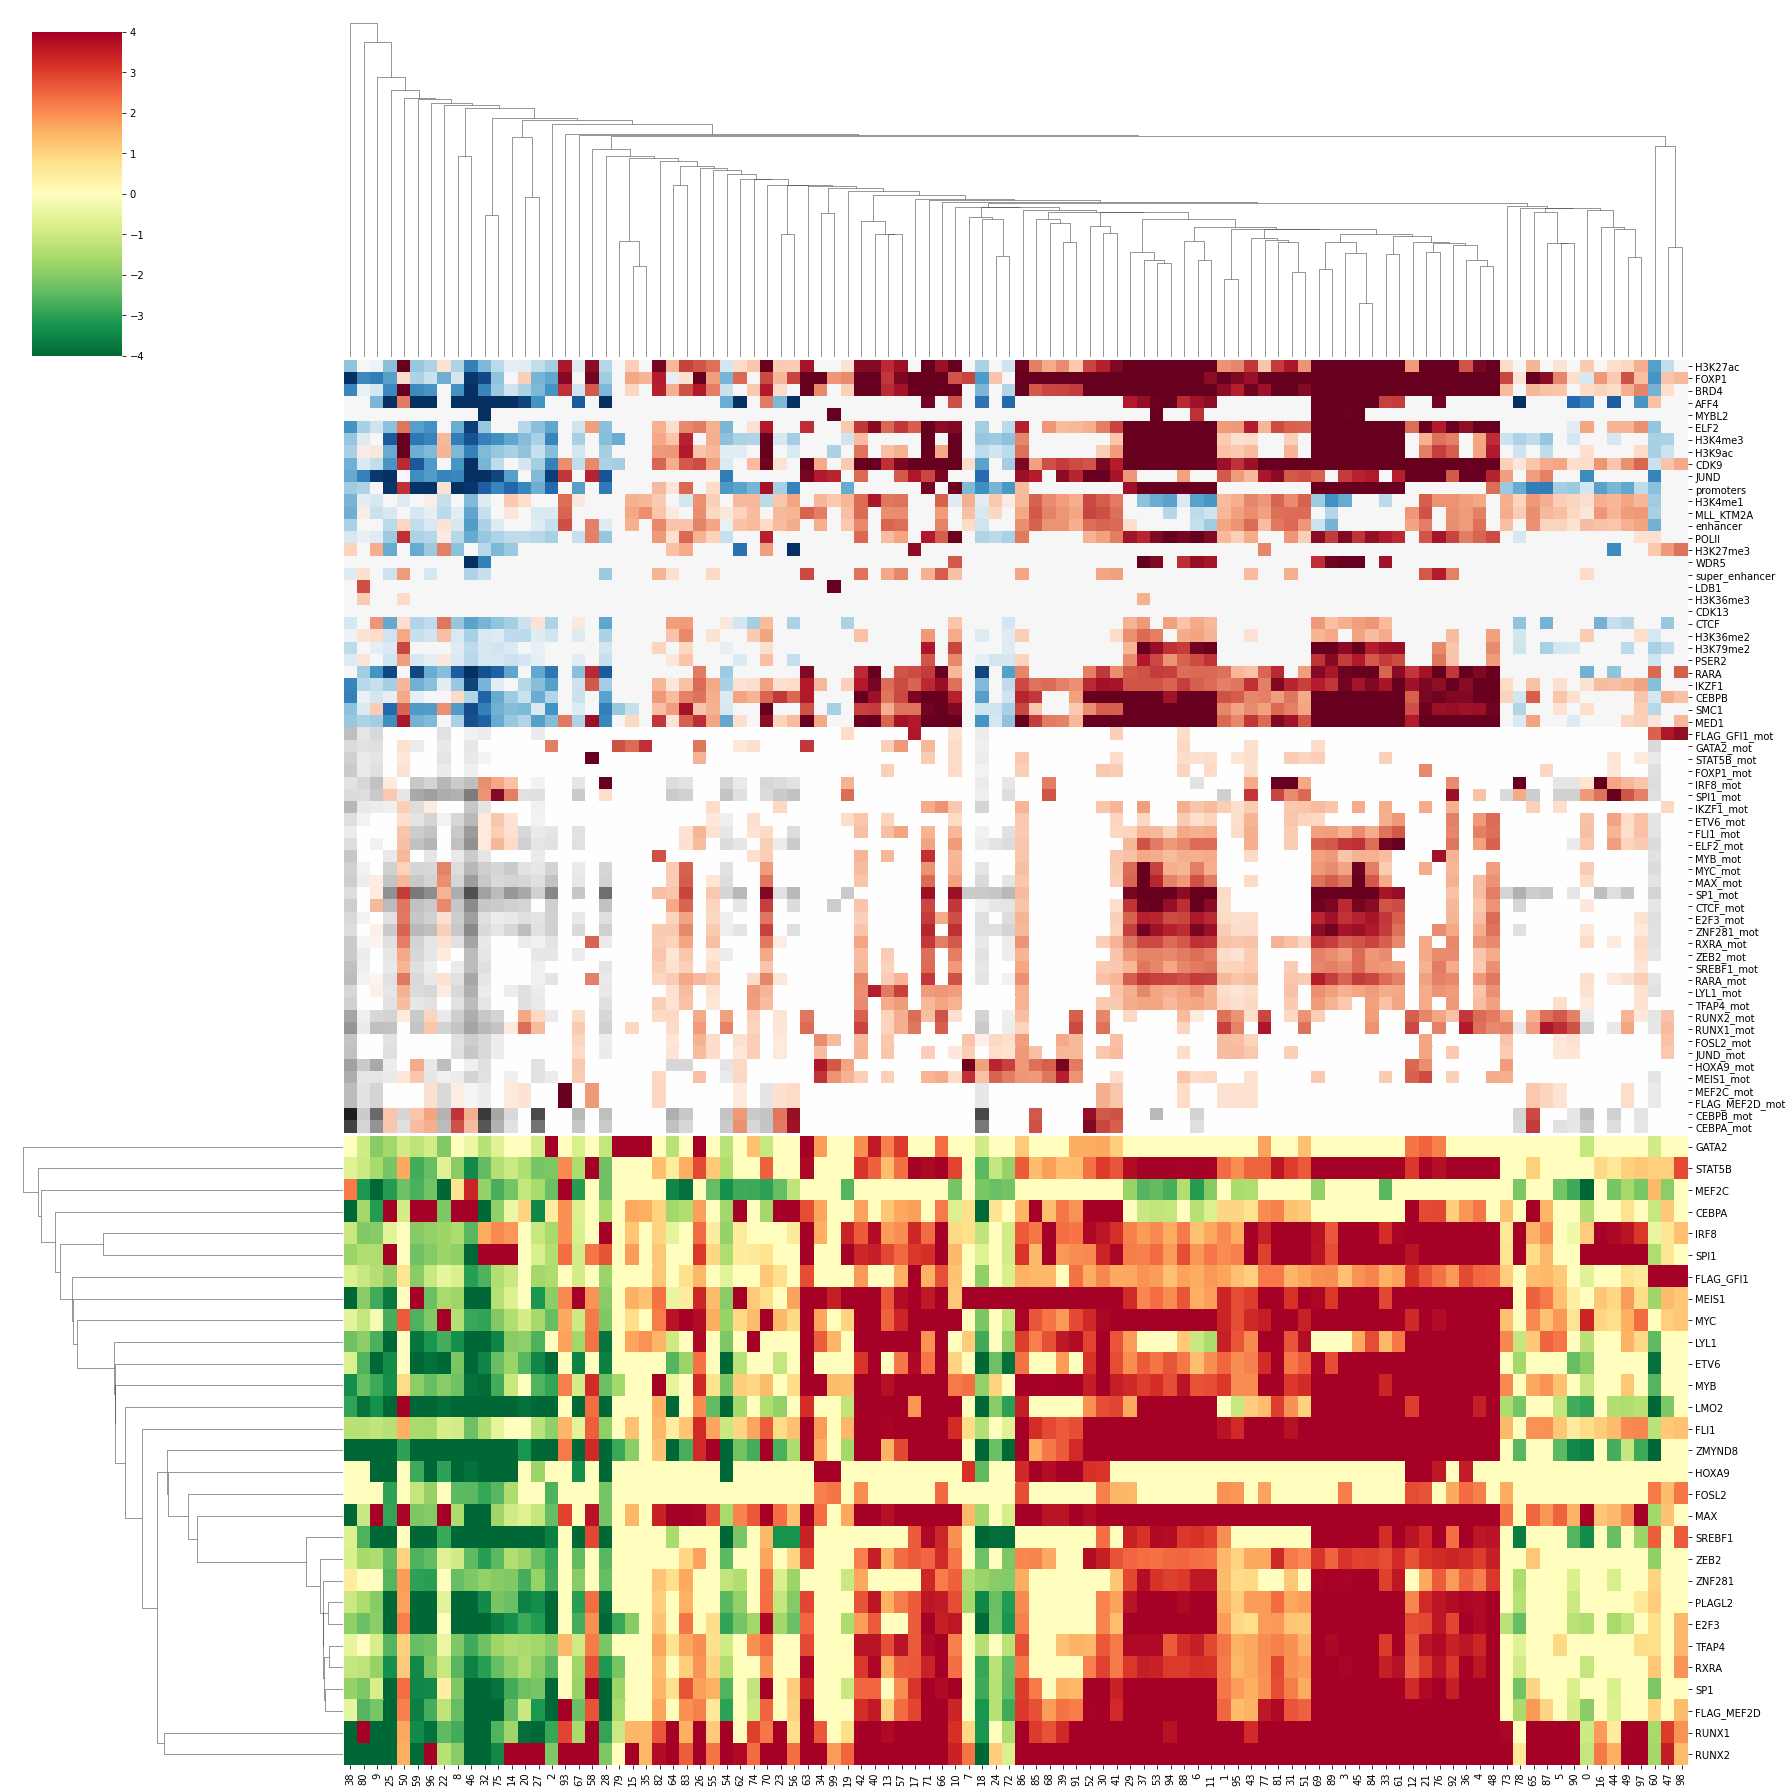

In [605]:
maxv=4
rdb = cm.get_cmap('RdBu_r', 256)
rdy = cm.get_cmap('RdGy_r', 256)
vals = merged.columns[cols:annot]
col = enr.loc[merged.columns[annot:]].copy().T
col[col<-maxv]=-maxv
col[col>maxv]=maxv
col = col/maxv
collink = order
rowlink = linkage(enr.loc[merged.columns[cols:annot]], metric="cosine")
rowlinkMot = linkage(enr.loc[merged.columns[annot:motloc+cols]])
rowlinkAdd = linkage(enr.loc[merged.columns[motloc+cols:motannot+cols]], metric="cosine")
for val in merged.columns[annot:motloc+cols].tolist():
    col[val] =[rdb(128+int(v*128)) for v in col[val]]
for val in merged.columns[motloc+cols:motannot+cols].tolist():
    col[val] =[rdy(128+int(v*128)) for v in col[val]]
col = col[[col.columns[i] for i in list(leaves_list(rowlinkMot)) + list(len(leaves_list(rowlinkMot)) + leaves_list(rowlinkAdd))]]
fig = sns.clustermap(enr.loc[merged.columns[cols:annot]], figsize=(25,25), vmax=4, vmin=-4, cmap='RdYlGn_r', col_colors=col, colors_ratio=0.007, col_linkage=collink, row_linkage=rowlink)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/motifs_and_crc_enrichment_on_clusters_'+str(n_clust[n])+'_v1.pdf')
plt.show()

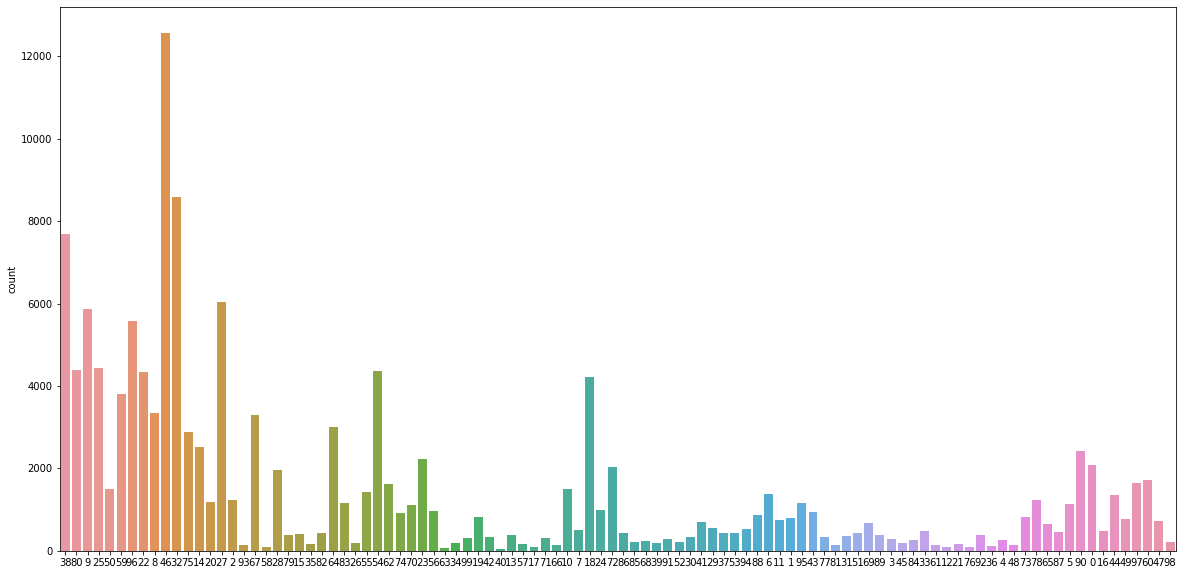

In [606]:
f, ax = plt.subplots(figsize=(20,10))
sns.countplot(groups.astype(str).tolist(), ax=ax, order=leaves_list(order).astype(str).tolist())
plt.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/cluster_size_'+str(n_clust[n])+'.pdf')

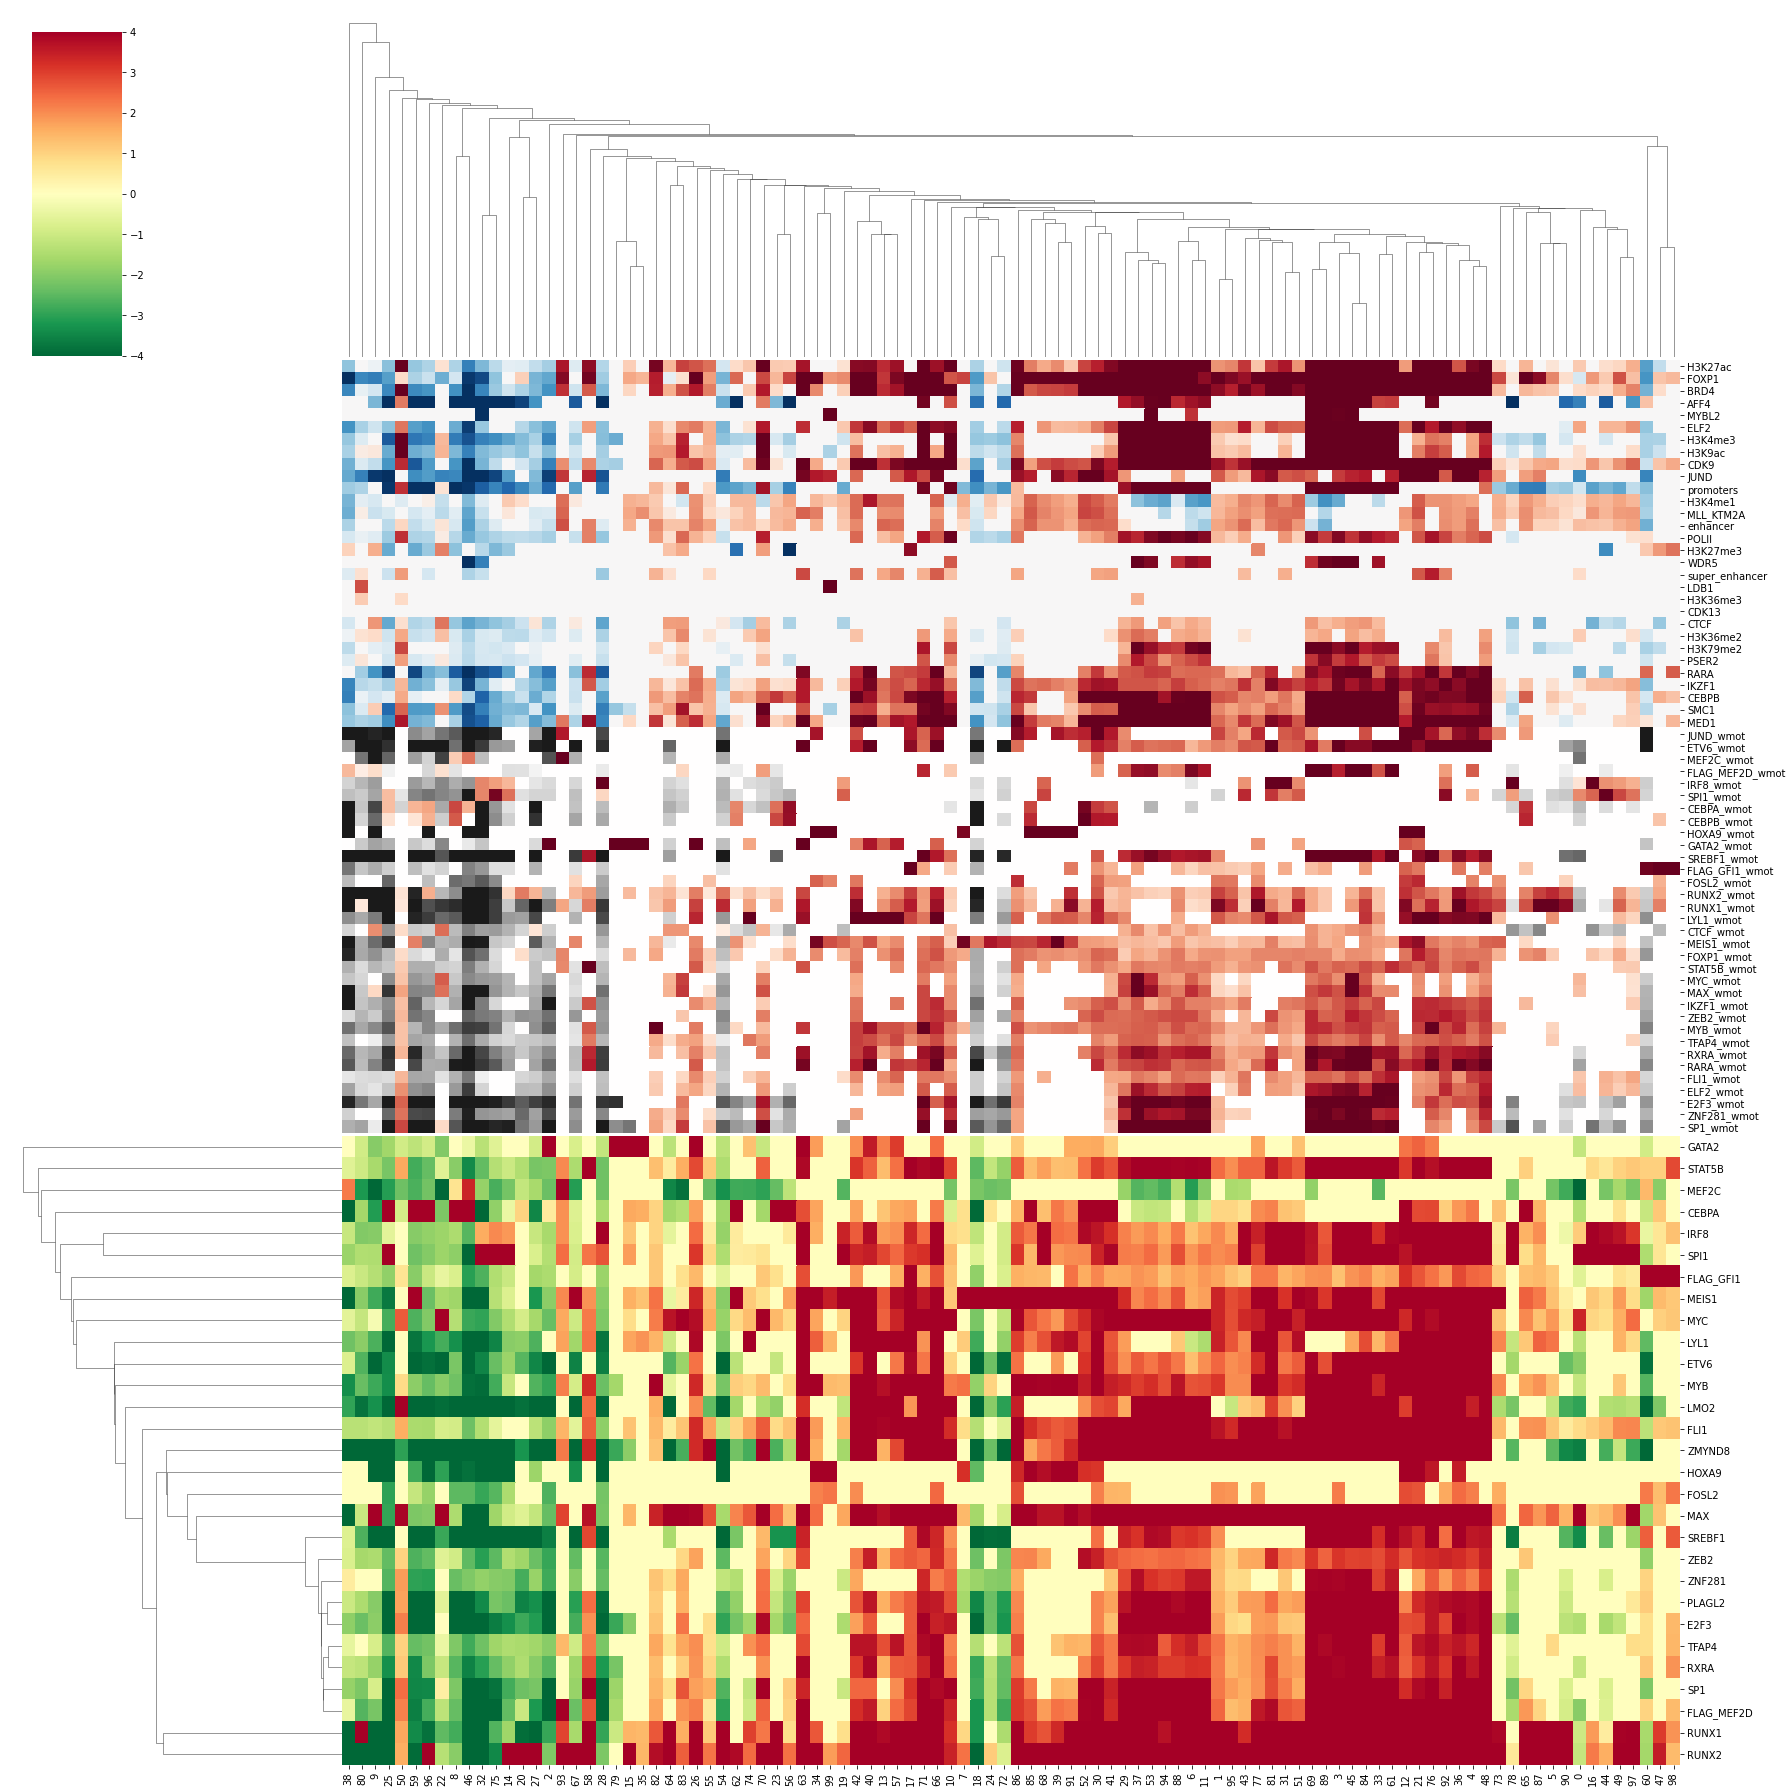

In [608]:
maxv=4
rdb = cm.get_cmap('RdBu_r', 256)
rdy = cm.get_cmap('RdGy_r', 256)
vals = merged.columns[cols:annot]
col = enr.loc[merged.columns[annot:motloc + cols].tolist() + merged.columns[motmergedloc+cols:].tolist()].copy().T
col[col<-maxv]=-maxv
col[col>maxv]=maxv
col = col/maxv
collink = order
rowlink = linkage(enr.loc[merged.columns[cols:annot]], metric="cosine")
rowlinkMot = linkage(enr.loc[merged.columns[annot:motloc+cols]])
rowlinkAdd = linkage(enr.loc[merged.columns[motmergedloc+cols:-9]], metric="cosine")
for val in merged.columns[annot:motloc+cols].tolist():
    col[val] =[rdb(128+int(v*128)) for v in col[val]]
for val in merged.columns[motmergedloc+cols:-9].tolist():
    col[val] =[rdy(128+int(v*128)) for v in col[val]]
col = col[[col.columns[i] for i in list(leaves_list(rowlinkMot)) + list(len(leaves_list(rowlinkMot)) + leaves_list(rowlinkAdd))]]
fig = sns.clustermap(enr.loc[merged.columns[cols:annot]], figsize=(25,25), vmax=4, vmin=-4, cmap='RdYlGn_r', col_colors=col, colors_ratio=0.007, col_linkage=collink, row_linkage=rowlink)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/motifs_and_crc_enrichment_on_clusters_'+str(n_clust[n])+'_with_wMot.pdf')
plt.show()

### interactive

Let's make it interactive

In [186]:
plot.heatmap(enr[leaves_list(collink)].iloc[leaves_list(rowlink).tolist()+((annot-cols)+leaves_list(rowlinkMot)).tolist()+(motmergedloc+leaves_list(rowlinkAdd)).tolist()], maxval=4, minval=-4, interactive=True, pvals=pvals[leaves_list(collink)].iloc[leaves_list(rowlink).tolist()+((annot-cols)+leaves_list(rowlinkMot)).tolist()+(motmergedloc+leaves_list(rowlinkAdd)).tolist()], maxokpval=10**-9, folder = '../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/', title = 'motifs_and_crc_enrichment_on_clusters_'+str(n_clust[n])+'_with_wMot')

we are assuming you want to display the pvals of your correlation with size


/home/jeremie/.local/lib/python3.8/site-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/.local/lib/python3.8/site-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


Figure(id='2503', ...)

## Simple predictions

In [235]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.neural_network import MLPClassifier
import pickle

stratified cross classification?

In [273]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(),)),
  ('classification', LogisticRegressionCV())
])

features = {}
tests = {}
clfs= {}

data = merged[merged.columns[cols:annot]].values
#data = ((data - data.min(1)) / (data.max(1) - data.min(1)))
data = data.astype(bool)
for val in range(data.shape[1]):
    print(val, end='\r')
    names = merged.columns[cols:annot].tolist()
    name = merged.columns[cols + val]
    names.remove(name)
    size = len(merged[merged[name]!=0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
    
    train = np.append(data[np.random.choice(merged[merged[name]!=0].index, neg)], data[np.random.choice(merged[merged[name]==0].index, pos)], 0)

    cl = clf.fit(np.delete(train, val, 1), train[:, val])
    
    clfs[name] = pickle.dumps(clf.get_params()['classification'])
    features[name] =  [np.array(names)[cl['feature_selection'].get_support()].tolist(), cl['classification'].coef_.tolist(), cl['classification'].intercept_[0], pos]
    
    test = np.append(data[np.random.choice(merged[merged[name] != 0].index, 500)], data[np.random.choice(merged[merged[name] == 0].index, 500)], 0)
    tests[name] = clf.score(np.delete(test, val, 1), test[:, val])

In [268]:
tests

{'FLAG_GFI1': 0.67,
 'CEBPA': 0.532,
 'HOXA9': 0.763,
 'PLAGL2': 0.838,
 'MEIS1': 0.647,
 'ETV6': 0.796,
 'RUNX1': 0.709,
 'FOSL2': 0.717,
 'FLI1': 0.673,
 'GATA2': 0.537,
 'SP1': 0.76,
 'E2F3': 0.852,
 'ZNF281': 0.705,
 'SREBF1': 0.876,
 'LMO2': 0.844,
 'STAT5B': 0.746,
 'ZMYND8': 0.859,
 'LYL1': 0.769,
 'MYC': 0.75,
 'TFAP4': 0.727,
 'RUNX2': 0.691,
 'MAX': 0.772,
 'IRF8': 0.723,
 'MYB': 0.792,
 'ZEB2': 0.749,
 'RXRA': 0.756,
 'SPI1': 0.73,
 'MEF2C': 0.731,
 'FLAG_MEF2D': 0.756}

In [262]:
tests

{'FLAG_GFI1': 0.512,
 'CEBPA': 0.564,
 'HOXA9': 0.709,
 'PLAGL2': 0.732,
 'MEIS1': 0.575,
 'ETV6': 0.798,
 'RUNX1': 0.657,
 'FOSL2': 0.611,
 'FLI1': 0.617,
 'GATA2': 0.539,
 'SP1': 0.747,
 'E2F3': 0.785,
 'ZNF281': 0.722,
 'SREBF1': 0.856,
 'LMO2': 0.798,
 'STAT5B': 0.694,
 'ZMYND8': 0.807,
 'LYL1': 0.651,
 'MYC': 0.686,
 'TFAP4': 0.619,
 'RUNX2': 0.696,
 'MAX': 0.72,
 'IRF8': 0.666,
 'MYB': 0.684,
 'ZEB2': 0.672,
 'RXRA': 0.749,
 'SPI1': 0.661,
 'MEF2C': 0.687,
 'FLAG_MEF2D': 0.762}

### lr

In [274]:
for k, v in tests.items():
    a = merged.columns[cols:annot].tolist()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(features[k])

______________________
FLAG_GFI1 0.671
[['MEIS1', 'RUNX1', 'ZNF281', 'STAT5B', 'TFAP4', 'MAX', 'IRF8', 'MYB'], [[0.16838307723898382, 0.6141861201372192, 0.3272809735657469, 0.8008210359760883, 0.404121470121156, 0.28522119517574973, 0.12130803631538814, 0.204396300236134]], -0.34158905471629286, 10000]
______________________
CEBPA 0.549
[['FLAG_GFI1', 'RUNX1', 'FLI1', 'GATA2', 'ZNF281', 'STAT5B', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'RXRA', 'SPI1', 'MEF2C'], [[0.24284390107121365, 0.029067130366595306, 0.449980416865313, 0.6880524234477003, -0.7880878401234671, 0.13477805678745636, -0.22887848359250412, -0.057592356078057634, 0.4565816950368721, -0.22614654304276077, -0.04978963545638222, 0.09339545646349134, -0.30282804505258837, 1.0281918920389874]], 0.5596668951348139, 10000]
______________________
HOXA9 0.785
[['MEIS1', 'LYL1', 'MYB'], [[1.8044404198590842, 1.5139680741753152, 1.0323682456593142]], -1.2430759105596114, 1000]
______________________
PLAGL2 0.823
[['FLI1', 'SP1', 

In [456]:
## cases that deviate from co-expression
## bio pathways/networks similarity?

##### without DT feature selection

In [213]:
for k, v in tests.items():
    a = merged.columns[cols:annot].tolist()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(features[k])

______________________
FLAG_GFI1 0.664
[['RUNX1', 'FOSL2', 'SREBF1', 'LMO2', 'STAT5B', 'MYC', 'TFAP4', 'RUNX2', 'RXRA', 'MEF2C', 'FLAG_MEF2D'], [[0.48679359093593966, 0.23119759975128615, 0.2554111603624626, -0.28075125945612295, 0.6493519282773159, 0.4592313832669707, 0.2641093467727385, 0.3594275286928866, 0.32909941848930346, -0.30055621769189916, 0.4552689148515473]], -0.39524623617943266, 10000]
______________________
CEBPA 0.534
[['PLAGL2', 'MEIS1', 'ETV6', 'GATA2', 'E2F3', 'ZNF281', 'ZMYND8', 'RUNX2', 'MYB', 'ZEB2', 'SPI1', 'MEF2C'], [[-0.4436654627275307, 0.5098838667116063, 0.44844980792512756, 0.4339899874971079, -0.8256021490779536, -0.6353853866584815, 0.41482449648225217, 0.35059942658183374, 0.5900712324827294, 0.3813059561466578, -0.3968375996320601, 1.127471317021293]], 0.3993684501480609, 10000]
______________________
HOXA9 0.783
[['MEIS1', 'GATA2', 'LYL1', 'RUNX2', 'MYB', 'SPI1', 'MEF2C', 'FLAG_MEF2D'], [[2.5362456607395836, 1.4804731072709245, 1.1877117182044776, 0.4

### making an adjacency graph

In [283]:
connections = pd.DataFrame(data=np.zeros((len(merged.columns[cols:annot]),len(merged.columns[cols:annot]))),
                          columns = merged.columns[cols:annot].tolist(), index = merged.columns[cols:annot].tolist()).astype(int)
for k, v in tests.items():
    connections.loc[k, features[k][0]]=1

In [286]:
import networkx as nx

In [291]:
net = nx.from_pandas_adjacency(connections.T,create_using=nx.DiGraph)
pos = nx.nx_agraph.graphviz_layout(net, prog="neato")

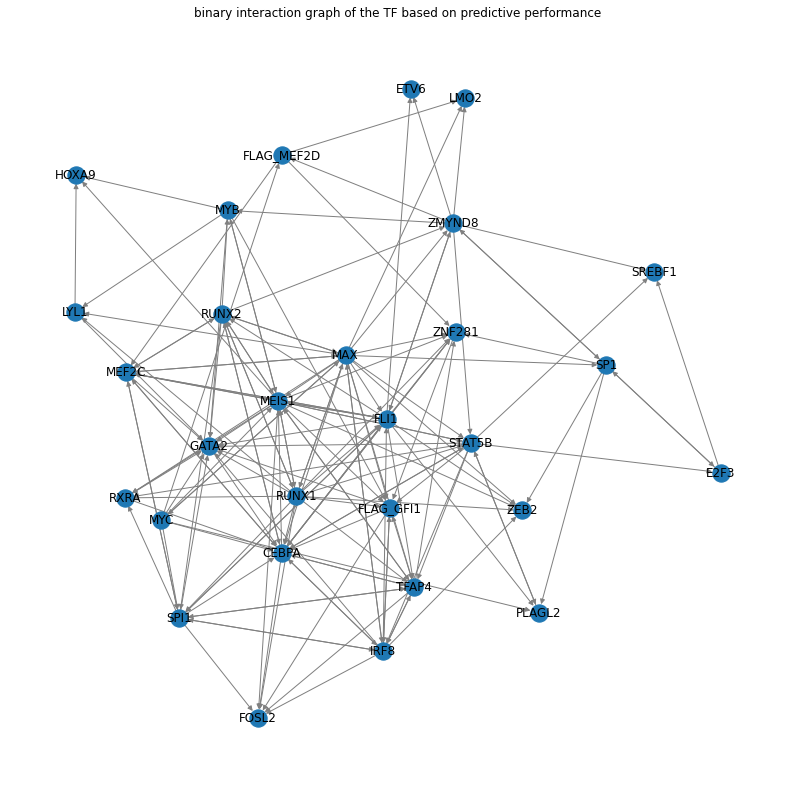

<Figure size 432x288 with 0 Axes>

In [294]:
plt.figure(figsize=(14, 14))
ax = plt.gca()
ax.set_title('binary interaction graph of the TF based on predictive performance')
nx.draw(net,pos,with_labels=True, edge_color="grey")
plt.show()
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/interaction_graph_binary.pdf")

### DT

In [167]:
for k, v in tests.items():
    a = merged.columns[cols:annot].tolist()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(features[k])
    if v >1.8:
    ## SHOW TREE
        plt.figure(figsize=(20,20))
        _ = plot_tree(pickle.loads(clfs[k]), label="root", feature_names=a, impurity=False, filled=True)
        plt.show()

______________________
FLAG_GFI1 0.657
[['MEIS1', 'RUNX1', 'STAT5B', 'MYC', 'TFAP4', 'MAX', 'IRF8', 'MYB', 'SPI1'], [0.04683173296889446, 0.2300969580901184, 0.5070099448552323, 0.08508269739874506, 0.02969957183438822, 0.03577746729338732, 0.023698900527788017, 0.02050604913673431, 0.02129667789471179], 10000]
______________________
CEBPA 0.655
[['RUNX1', 'FLI1', 'ZNF281', 'STAT5B', 'MYC', 'TFAP4', 'MAX', 'IRF8', 'SPI1', 'MEF2C'], [0.1140613812726762, 0.0524787546281615, 0.044376552986324355, 0.06608670722044534, 0.10571409513369966, 0.06542717960476137, 0.19318896063300475, 0.13668325670547604, 0.1452711620439095, 0.07671194977154124], 10000]
______________________
HOXA9 0.764
[['CEBPA', 'MEIS1', 'LYL1', 'MYB', 'SPI1'], [0.012810532381786038, 0.6390879653562651, 0.20737774593437505, 0.08454716805879466, 0.05617658826877905], 1000]
______________________
PLAGL2 0.827
[['FLI1', 'SP1', 'STAT5B'], [0.06917659653931606, 0.20998360477697953, 0.7208397986837045], 10000]
____________________

## Predicting non CRC binding from CRCs

In [326]:
merged.columns[annot:67]

Index(['ELF2', 'JUND', 'SMC1', 'LDB1', 'H3K79me2', 'WDR5', 'H3K27ac',
       'H3K27me3', 'MYBL2', 'CDK9', 'H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA',
       'IKZF1', 'AFF4', 'CTCF', 'BRD4', 'CEBPB', 'H3K36me2', 'PSER2',
       'H3K36me3', 'H3K9ac', 'CDK13', 'H3K4me1', 'POLII', 'MED1', 'promoters',
       'enhancer', 'super_enhancer'],
      dtype='object')

In [348]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(),)),
  ('classification', LogisticRegressionCV())
])

features = {}
tests = {}
clfs= {}

selected_col = merged.columns[annot:67].tolist()
inpdata = merged[merged.columns[cols:annot]].values
outpdata = merged[selected_col].values
#data = ((data - data.min(1)) / (data.max(1) - data.min(1)))
inpdata = inpdata.astype(bool)
outpdata = outpdata.astype(bool)
for val in range(outpdata.shape[1]):
    print(val, end='\r')
    names = selected_col.copy()
    name = names.pop(val)
    size = len(merged[merged[name]!=0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
    
    poslist = np.random.choice(merged[merged[name]!=0].index, neg) 
    neglist = np.random.choice(merged[merged[name]==0].index, pos)
    inptrain = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptrain = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)

    cl = clf.fit(inptrain, outptrain)
    
    clfs[name] = pickle.dumps(clf.get_params()['classification'])
    features[name] =  [merged.columns[cols:annot].values[cl['feature_selection'].get_support()].tolist(), cl['classification'].coef_.tolist(), cl['classification'].intercept_[0], pos]
    
    poslist = np.random.choice(merged[merged[name]!=0].index, 500) 
    neglist = np.random.choice(merged[merged[name]==0].index, 500)
                 
    inptest = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptest = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)
                 
    tests[name] = clf.score(inptest, outptest)

In [346]:
tests

{'ELF2': 0.794,
 'JUND': 0.825,
 'SMC1': 0.774,
 'LDB1': 0.79,
 'H3K79me2': 0.551,
 'WDR5': 0.827,
 'H3K27ac': 0.754,
 'H3K27me3': 0.662,
 'MYBL2': 0.874,
 'CDK9': 0.783,
 'H3K4me3': 0.746,
 'FOXP1': 0.789,
 'MLL_KTM2A': 0.629,
 'RARA': 0.88,
 'IKZF1': 0.744,
 'AFF4': 0.867,
 'CTCF': 0.691,
 'BRD4': 0.769,
 'CEBPB': 0.673,
 'H3K36me2': 0.605,
 'PSER2': 0.531,
 'H3K36me3': 0.501,
 'H3K9ac': 0.708,
 'CDK13': 0.836,
 'H3K4me1': 0.621,
 'POLII': 0.653,
 'MED1': 0.755,
 'promoters': 0.864,
 'enhancer': 0.641,
 'super_enhancer': 0.579}

In [349]:
for k, v in tests.items():
    print("______________________")
    print(k, v)
    print(features[k])

______________________
ELF2 0.758
[['FLI1', 'MAX'], [[1.222963965293382, 0.8959644493314735]], -0.5975591936685415, 10000]
______________________
JUND 0.854
[['CEBPA', 'MEIS1', 'FOSL2', 'LYL1', 'MAX', 'MYB'], [[1.12721527323289, 1.0700470589188573, 3.1565588581273794, 1.2406316434237414, 0.9085362569376583, 1.3576875383355231]], -2.5865058581967193, 3000]
______________________
SMC1 0.762
[['CEBPA', 'SP1', 'MAX'], [[-0.35802355592687246, 0.8623711795891682, 1.1056311400651686]], -0.09786650666706685, 10000]
______________________
LDB1 0.811
[['CEBPA', 'RUNX1', 'GATA2', 'ZNF281', 'TFAP4', 'RUNX2', 'ZEB2', 'SPI1'], [[0.4681360491969098, 0.7444404316434864, 2.559228868424266, 0.36727596623449893, 0.4703976323265764, -0.18624954488083575, 1.5196571212826069, -1.497434667749822]], -0.6072111694815278, 1000]
______________________
H3K79me2 0.543
[['FLAG_GFI1', 'MEIS1', 'RUNX1', 'FLI1', 'LMO2', 'TFAP4', 'RUNX2', 'SPI1', 'MEF2C'], [[0.002435486939367166, 0.010820633230840001, 0.139282255662047

## Simple prediction using putative DNA bound CRCs 

In [339]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(),)),
  ('classification', LogisticRegressionCV())
])

features = {}
tests = {}
clfs= {}
selected_col = [val+'_wmot' if val+'_wmot' in merged.columns else val for val in merged.columns[cols:annot]]
data = merged[selected_col].values
#data = ((data - data.min(1)) / (data.max(1) - data.min(1)))
data = data.astype(bool)
for val in range(data.shape[1]):
    names = selected_col.copy()
    name = selected_col[val]
    names.remove(name)
    print(name)
    size = len(merged[merged[name]!=0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
    
    train = np.append(data[np.random.choice(merged[merged[name]!=0].index, neg)], data[np.random.choice(merged[merged[name]==0].index, pos)], 0)

    cl = clf.fit(np.delete(train, val, 1), train[:, val])
    
    clfs[name] = pickle.dumps(clf.get_params()['classification'])
    features[name] =  [np.array(names)[cl['feature_selection'].get_support()].tolist(), cl['classification'].coef_.tolist(), cl['classification'].intercept_[0], pos]
    
    test = np.append(data[np.random.choice(merged[merged[name] != 0].index, 500)], data[np.random.choice(merged[merged[name] == 0].index, 500)], 0)
    tests[name] = clf.score(np.delete(test, val, 1), test[:, val])

FLAG_GFI1_wmot
CEBPA_wmot
HOXA9_wmot
PLAGL2
MEIS1_wmot
ETV6_wmot
RUNX1_wmot
FOSL2_wmot
FLI1_wmot
GATA2_wmot
SP1_wmot
E2F3_wmot
ZNF281_wmot
SREBF1_wmot
LMO2
STAT5B_wmot
ZMYND8
LYL1_wmot
MYC_wmot
TFAP4_wmot
RUNX2_wmot
MAX_wmot
IRF8_wmot
MYB_wmot
ZEB2_wmot
RXRA_wmot
SPI1_wmot
MEF2C_wmot
FLAG_MEF2D_wmot


In [320]:
tests

{'FLAG_GFI1_wmot': 0.501,
 'CEBPA_wmot': 0.508,
 'HOXA9_wmot': 0.826,
 'PLAGL2': 0.834,
 'MEIS1_wmot': 0.5,
 'ETV6_wmot': 0.872,
 'RUNX1_wmot': 0.794,
 'FOSL2_wmot': 0.587,
 'FLI1_wmot': 0.657,
 'GATA2_wmot': 0.5,
 'SP1_wmot': 0.837,
 'E2F3_wmot': 0.881,
 'ZNF281_wmot': 0.792,
 'SREBF1_wmot': 0.902,
 'LMO2': 0.85,
 'STAT5B_wmot': 0.659,
 'ZMYND8': 0.816,
 'LYL1_wmot': 0.78,
 'MYC_wmot': 0.739,
 'TFAP4_wmot': 0.671,
 'RUNX2_wmot': 0.5,
 'MAX_wmot': 0.769,
 'IRF8_wmot': 0.5,
 'MYB_wmot': 0.713,
 'ZEB2_wmot': 0.766,
 'RXRA_wmot': 0.799,
 'SPI1_wmot': 0.5,
 'MEF2C_wmot': 0.772,
 'FLAG_MEF2D_wmot': 0.541}

In [322]:
for k, v in tests.items():
    a = selected_col.copy()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(features[k])

______________________
FLAG_GFI1_wmot 0.501
[['MEIS1_wmot', 'RUNX1_wmot', 'FLI1_wmot', 'SP1_wmot', 'E2F3_wmot', 'ZNF281_wmot', 'LMO2', 'ZMYND8', 'MYC_wmot', 'TFAP4_wmot', 'RUNX2_wmot', 'MAX_wmot', 'IRF8_wmot', 'MYB_wmot', 'SPI1_wmot', 'FLAG_MEF2D_wmot'], [[0.42273997340245106, 0.37125832135765185, 0.11759609893443496, 0.09834809406059623, 0.13533022742485526, 0.047611856683265785, -0.11248427085545867, 0.7442429963303893, 0.05203539861000727, 0.368821150599164, 0.30633232930562776, 0.14442908449060976, 0.09028741780129707, 0.24535994559409427, 0.19087027317490202, -0.297989485557332]], 0.32746315581871327, 7000]
______________________
CEBPA_wmot 0.508
[['PLAGL2', 'MEIS1_wmot', 'FLI1_wmot', 'SP1_wmot', 'ZNF281_wmot', 'LMO2', 'STAT5B_wmot', 'ZMYND8', 'MYC_wmot', 'TFAP4_wmot', 'RUNX2_wmot', 'MAX_wmot', 'MYB_wmot'], [[-0.24749195340723623, 0.2516166577416737, -0.18694438777048417, -0.5265794604291657, -0.23847844451514674, 0.0021421922598454206, 0.18741145555490196, 0.3783694670465588, -0.

### making an adjacency graph

In [341]:
connections = pd.DataFrame(data=np.zeros((len(selected_col),len(selected_col))),
                          columns = selected_col, index = selected_col).astype(int)
for k, v in tests.items():
    connections.loc[k, features[k][0]]=1

In [342]:
import networkx as nx

In [343]:
net = nx.from_pandas_adjacency(connections.T,create_using=nx.DiGraph)
pos = nx.nx_agraph.graphviz_layout(net, prog="neato")

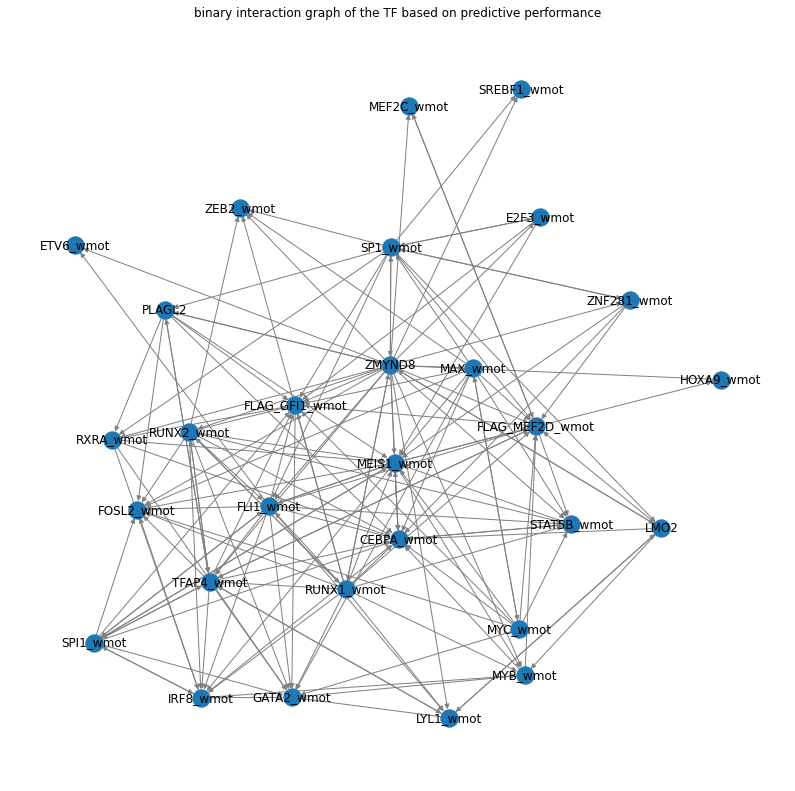

<Figure size 432x288 with 0 Axes>

In [344]:
plt.figure(figsize=(14, 14))
ax = plt.gca()
ax.set_title('binary interaction graph of the TF based on predictive performance')
nx.draw(net,pos,with_labels=True, edge_color="grey")
plt.show()
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/interaction_graph_binary_withmot.pdf")

## Predicting TF binding from non Tf binding features

In [359]:
[1,2,3,4].index(5)

ValueError: 5 is not in list

In [379]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(),)),
  ('classification', LogisticRegressionCV())
])

features = {}
tests = {}
clfs= {}
selected_col = [val+'_wmot' if val+'_wmot' in merged.columns else val for val in merged.columns[cols:annot]]
inpcol = ['H3K79me2', 'H3K27ac', 'H3K27me3', 'H3K4me3', 'CTCF', 'H3K36me2', 'H3K36me3', 'H3K9ac', 'H3K4me1', 'POLII', 'MED1', 'promoters', 'enhancer', 'super_enhancer', 'CTCF_mot', 'IRF8_mot', 'FOSL2_mot', 'STAT5B_mot', 'SPI1_mot', 'E2F3_mot', 'ZNF281_mot', 'LYL1_mot', 'MYB_mot', 'RUNX2_mot', 'JUND_mot', 'FLAG_GFI1_mot', 'MYC_mot', 'RUNX1_mot', 'MEF2C_mot', 'RXRA_mot', 'ETV6_mot', 'MAX_mot', 'SREBF1_mot', 'IKZF1_mot', 'FOXP1_mot', 'CEBPB_mot', 'GATA2_mot', 'CEBPA_mot', 'HOXA9_mot', 'FLI1_mot', 'MEIS1_mot', 'ZEB2_mot', 'RARA_mot', 'TFAP4_mot', 'ELF2_mot', 'SP1_mot', 'FLAG_MEF2D_mot']
inpdata = merged[inpcol].values
outpdata = merged[selected_col].values
#data = ((data - data.min(1)) / (data.max(1) - data.min(1)))
inpdata = inpdata.astype(bool)
outpdata = outpdata.astype(bool)
for val in range(outpdata.shape[1]):
    names = inpcol.copy()
    name = selected_col[val]
    print(name)
    size = len(merged[merged[name]!=0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
        
    poslist = np.random.choice(merged[merged[name]!=0].index, neg) 
    neglist = np.random.choice(merged[merged[name]==0].index, pos)
    nname = name.replace('_wmot','_mot')
    if nname in inpcol:
        ind = inpcol.index(nname)
        inptrain = np.append(np.delete(inpdata[poslist], ind, 1), np.delete(inpdata[neglist], ind, 1), 0)
        names.remove(nname)
    else:
        inptrain = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptrain = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)

    cl = clf.fit(inptrain, outptrain)
    
    clfs[name] = pickle.dumps(clf.get_params()['classification'])
    features[name] =  [np.array(names)[cl['feature_selection'].get_support()].tolist(), cl['classification'].coef_.tolist(), cl['classification'].intercept_[0], pos]
    
    poslist = np.random.choice(merged[merged[name]!=0].index, 500) 
    neglist = np.random.choice(merged[merged[name]==0].index, 500)
    if nname in inpcol:
        ind = inpcol.index(nname)
        inptest = np.append(np.delete(inpdata[poslist], ind, 1), np.delete(inpdata[neglist], ind, 1), 0)
    else:
        inptest = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptest = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)
    
    tests[name] = clf.score(inptest, outptest)

FLAG_GFI1_wmot
CEBPA_wmot
HOXA9_wmot
PLAGL2
MEIS1_wmot
ETV6_wmot
RUNX1_wmot
FOSL2_wmot
FLI1_wmot
GATA2_wmot
SP1_wmot
E2F3_wmot
ZNF281_wmot
SREBF1_wmot
LMO2
STAT5B_wmot
ZMYND8
LYL1_wmot
MYC_wmot
TFAP4_wmot
RUNX2_wmot
MAX_wmot
IRF8_wmot
MYB_wmot
ZEB2_wmot
RXRA_wmot
SPI1_wmot
MEF2C_wmot
FLAG_MEF2D_wmot


In [380]:
tests

{'FLAG_GFI1_wmot': 0.588,
 'CEBPA_wmot': 0.851,
 'HOXA9_wmot': 0.8,
 'PLAGL2': 0.792,
 'MEIS1_wmot': 0.654,
 'ETV6_wmot': 0.789,
 'RUNX1_wmot': 0.739,
 'FOSL2_wmot': 0.877,
 'FLI1_wmot': 0.758,
 'GATA2_wmot': 0.518,
 'SP1_wmot': 0.903,
 'E2F3_wmot': 0.848,
 'ZNF281_wmot': 0.79,
 'SREBF1_wmot': 0.868,
 'LMO2': 0.904,
 'STAT5B_wmot': 0.692,
 'ZMYND8': 0.798,
 'LYL1_wmot': 0.732,
 'MYC_wmot': 0.751,
 'TFAP4_wmot': 0.686,
 'RUNX2_wmot': 0.712,
 'MAX_wmot': 0.822,
 'IRF8_wmot': 0.501,
 'MYB_wmot': 0.736,
 'ZEB2_wmot': 0.774,
 'RXRA_wmot': 0.752,
 'SPI1_wmot': 0.681,
 'MEF2C_wmot': 0.918,
 'FLAG_MEF2D_wmot': 0.972}

In [381]:
for k, v in tests.items():
    print("______________________")
    print(k, v)
    print(features[k])

______________________
FLAG_GFI1_wmot 0.588
[['H3K79me2', 'H3K36me2', 'H3K9ac', 'H3K4me1', 'POLII', 'MED1', 'CTCF_mot', 'IRF8_mot', 'SPI1_mot', 'E2F3_mot', 'LYL1_mot', 'MYB_mot', 'RUNX1_mot', 'RXRA_mot', 'ETV6_mot', 'SREBF1_mot', 'FOXP1_mot', 'CEBPB_mot', 'GATA2_mot', 'FLI1_mot', 'MEIS1_mot', 'RARA_mot', 'TFAP4_mot'], [[-0.0072792076570007995, -0.10640230774091464, -0.1686989162207562, 0.04011363325488485, 0.011338379965432606, 0.611130153503931, 0.22000000119250976, 0.09988645955229904, 0.15217109662597433, 0.14238768260025836, -0.10038460518868596, 0.17527622832058395, 0.3322505853940122, 0.19068471749883573, 0.11399853121041945, 0.47521342421542934, 0.19405942259275402, 0.6958955367551002, 0.09281160319225681, 0.011606747759132932, 0.30741851354772426, 0.2455410305434205, 0.3402120993019501]], -0.40413386269359824, 7000]
______________________
CEBPA_wmot 0.851
[['CEBPB_mot', 'RARA_mot'], [[3.2317311629128045, -0.045885792582284986]], -0.42258892459339836, 10000]
____________________

## predicting differential binding from regular binding

In [ ]:
'POLII' , 'MED1'

In [396]:
merged.columns[30:67]

Index(['IRF8', 'MYB', 'ZEB2', 'RXRA', 'SPI1', 'MEF2C', 'FLAG_MEF2D', 'ELF2',
       'JUND', 'SMC1', 'LDB1', 'H3K79me2', 'WDR5', 'H3K27ac', 'H3K27me3',
       'MYBL2', 'CDK9', 'H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1',
       'AFF4', 'CTCF', 'BRD4', 'CEBPB', 'H3K36me2', 'PSER2', 'H3K36me3',
       'H3K9ac', 'CDK13', 'H3K4me1', 'POLII', 'MED1', 'promoters', 'enhancer',
       'super_enhancer'],
      dtype='object')

In [397]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(),)),
  ('classification', LogisticRegressionCV())
])

features = {}
tests = {}
clfs= {}
selected_col = merged.columns[-9:].tolist()
inpcol = merged.columns[cols:67].tolist()
inpdata = merged[inpcol].values
outpdata = merged[selected_col].values
#data = ((data - data.min(1)) / (data.max(1) - data.min(1)))
inpdata = inpdata.astype(bool)
outpdata = outpdata.astype(bool)
for val in range(outpdata.shape[1]):
    names = inpcol.copy()
    name = selected_col[val]
    print(name)
    size = len(merged[merged[name]!=0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
        
    poslist = np.random.choice(merged[merged[name]!=0].index, neg) 
    neglist = np.random.choice(merged[merged[name]==0].index, pos)
    
    inptrain = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptrain = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)

    cl = clf.fit(inptrain, outptrain)
    
    clfs[name] = pickle.dumps(clf.get_params()['classification'])
    features[name] =  [np.array(names)[cl['feature_selection'].get_support()].tolist(), cl['classification'].coef_.tolist(), cl['classification'].intercept_[0], pos]
    
    poslist = np.random.choice(merged[merged[name]!=0].index, 500) 
    neglist = np.random.choice(merged[merged[name]==0].index, 500)
    
    inptest = np.append(inpdata[poslist], inpdata[neglist], 0)
    outptest = np.append(outpdata[poslist, val], outpdata[neglist, val], 0)
    
    tests[name] = clf.score(inptest, outptest)

MYC-rmIRF8
MED1-rmIRF8
MYC-rmMEF2D
MEF2C-rmMEF2D
MEF2C-rmIRF8
IRF8-rmMEF2D
POLII_total-rmMEF2D
MED1-rmMEF2D
POLII_total-rmIRF8


IndexError: list index out of range

In [457]:
## need to get an estimation of variation of predictors, 
## have a control 

## make a set (MYC_change when rmIRF8)

In [398]:
tests

{'MYC-rmIRF8': 0.813,
 'MED1-rmIRF8': 0.827,
 'MYC-rmMEF2D': 0.833,
 'MEF2C-rmMEF2D': 0.776,
 'MEF2C-rmIRF8': 0.738,
 'IRF8-rmMEF2D': 0.827,
 'POLII_total-rmMEF2D': 0.872,
 'MED1-rmMEF2D': 0.882,
 'POLII_total-rmIRF8': 0.861}

In [389]:
tests

{'MYC-rmIRF8': 0.771,
 'MED1-rmIRF8': 0.773,
 'MYC-rmMEF2D': 0.828,
 'MEF2C-rmMEF2D': 0.74,
 'MEF2C-rmIRF8': 0.68,
 'IRF8-rmMEF2D': 0.806,
 'POLII_total-rmMEF2D': 0.735,
 'MED1-rmMEF2D': 0.828,
 'POLII_total-rmIRF8': 0.735}

In [399]:
for k, v in tests.items():
    print("______________________")
    print(k, v)
    print(features[k])

______________________
MYC-rmIRF8 0.813
[['MEIS1', 'RUNX1', 'MYC', 'RUNX2', 'MAX', 'SPI1', 'H3K36me2', 'MED1'], [[0.20293687785525782, 0.3284934013007881, 1.5963538687080547, 0.15927121870737276, 1.0948793328430397, -0.0709693806269327, 0.2885398735499491, 1.9398703723371005]], -1.7752803170667826, 10000]
______________________
MED1-rmIRF8 0.827
[['MAX', 'H3K27ac', 'BRD4', 'MED1'], [[0.5638095640263371, 1.0672649652144135, 0.8034033812707249, 2.0580104194281135]], -1.5647080863054053, 10000]
______________________
MYC-rmMEF2D 0.833
[['RUNX1', 'MYC', 'MAX', 'SPI1', 'CDK9', 'H3K9ac', 'H3K4me1'], [[0.5196682592202383, 1.1384755171372287, 0.8430129984251967, 0.11183174931580646, 0.4896408155965731, 0.43860910947415555, 0.12909487970715502]], -0.8763276213591983, 10000]
______________________
MEF2C-rmMEF2D 0.776
[['CEBPA', 'MEIS1', 'RUNX1', 'FLI1', 'ZMYND8', 'MYC', 'RUNX2', 'MAX', 'IRF8', 'SPI1', 'FLAG_MEF2D', 'H3K27ac', 'FOXP1', 'CEBPB', 'H3K36me2', 'H3K4me1', 'MED1'], [[-0.067338387391321

## Adding differential binding

In [230]:
projects = ["MEF2D_degraded_v2", "IRF8_degraded_v1","MEF2D_degraded_v1"]
for val in projects:
    helper.createFoldersFor("../data/"+project+"/"+val+"/beds/")
reena    ! gsutil cp gs://amlproject/Chip/$val/bwa/mergedLibrary/macs/broadPeak/*.broadPeak ../data/$project/$val/beds/

Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_peaks.broadPeak...
- [4 files][ 11.1 MiB/ 11.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-POLII_total_R1_peaks.br

In [238]:
rename = {}
rename['MEF2D_degraded_v1'] = {
    'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks': 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3',
    'MV411_MEF2D_NT_SC_63_DMSO-IFR8_R1_peaks': 'mp883-MV411_MEF2D_NT_SC_63_DMSO-IRF8-r1',
    'MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks': 'mp885-MV411_MEF2D_NT_SC_63_DMSO-MED1-r1',
    'MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peaks': 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1',
    'MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_peaks': 'mp889-MV411_MEF2D_NT_SC_63_DMSO-MYC-r1',
    'MV411_MEF2D_NT_SC_63_DMSO-POLII_R1_peaks': 'mp891-MV411_MEF2D_NT_SC_63_DMSO-POLII-r1',
    'MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_peaks': 'mp882-MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D-r1',
    'MV411_MEF2D_NT_SC_63_VHL-IFR8_R1_peaks': 'mp884-MV411_MEF2D_NT_SC_63_VHL-IRF8-r1',
    'MV411_MEF2D_NT_SC_63_VHL-MED1_R1_peaks': 'mp886-MV411_MEF2D_NT_SC_63_VHL-MED1-r1',
    'MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_peaks': 'mp888-MV411_MEF2D_NT_SC_63_VHL-MEF2C-r1',
    'MV411_MEF2D_NT_SC_63_VHL-MYC_R1_peaks': 'mp890-MV411_MEF2D_NT_SC_63_VHL-MYC-r1',
    'MV411_MEF2D_NT_SC_63_VHL-POLII_R1_R1_peaks': 'mp892-MV411_MEF2D_NT_SC_63_VHL-POLII-r1'
}
rename['MEF2D_degraded_v2'] = {
    'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks': "mp921-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r4",
    'MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks': "mp922-MV411_MEF2D_NT_SC_63_DMSO-MED1-r2",
    'MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peaks': "mp923-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r2",
    'MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_peaks': "mp924-MV411_MEF2D_NT_SC_63_DMSO-MYC-r2",
    'MV411_MEF2D_NT_SC_63_DMSO-POLII_total_R1_peaks': "mp925-MV411_MEF2D_NT_SC_63-POLII_total-r2",
    'MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_R1_peaks': "mp926-MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D-r4",
    'MV411_MEF2D_NT_SC_63_VHL-MED1_R1_peaks': "mp927-MV411_MEF2D_NT_SC_63_VHL-MED1-r2",
    'MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_peaks': "mp928-MV411_MEF2D_NT_SC_63_VHL-MEF2C-r2",
    'MV411_MEF2D_NT_SC_63_VHL-MYC_R1_peaks': "mp929-MV411_MEF2D_NT_SC_63_VHL-MYC-r2",
    'MV411_MEF2D_NT_SC_63_VHL-POLII_total_R1_peaks': "mp930-MV411_MEF2D_NT_SC_63_VHL-POLII_total-r2"
}
rename['IRF8_degraded_v1'] = {
    'MV411_IRF8_NT_DMSO-IRF8_R1_peaks': "mp901-MV411_IRF8_NT_DMSO-IRF8-r1",
    'MV411_IRF8_NT_DMSO-MED1_R1_peaks': "mp903-MV411_IRF8_NT_DMSO-MED1-r1",
    'MV411_IRF8_NT_DMSO-MEF2C_R1_peaks': "mp905-MV411_IRF8_NT_DMSO-MEF2C-r1",
    'MV411_IRF8_NT_DMSO-MEF2D_R1_peaks': "mp907-MV411_IRF8_NT_DMSO-MEF2D-r1",
    'MV411_IRF8_NT_DMSO-MYC_R1_peaks': "mp909-MV411_IRF8_NT_DMSO-MYC-r1",
    'MV411_IRF8_NT_DMSO-POLII_total_R1_peaks': "mp911-MV411_IRF8_NT_DMSO-POLII_total-r1",
    'MV411_IRF8_NT_VHL-IRF8_R1_peaks': "mp902-MV411_IRF8_NT_VHL-IRF8-r1",
    'MV411_IRF8_NT_VHL-MED1_R1_peaks': "mp904-MV411_IRF8_NT_VHL-MED1-r1",
    'MV411_IRF8_NT_VHL-MEF2C_R1_peaks': "mp906-MV411_IRF8_NT_VHL-MEF2C-r1",
    'MV411_IRF8_NT_VHL-MEF2D_R1_peaks': "mp908-MV411_IRF8_NT_VHL-MEF2D-r1",
    'MV411_IRF8_NT_VHL-MYC_R1_peaks': "mp910-MV411_IRF8_NT_VHL-MYC-r1",
    'MV411_IRF8_NT_VHL-POLII_total_R1_peaks': "mp912-MV411_IRF8_NT_VHL-POLII_total-r1",
}


In [240]:
for val in projects:
    files  = ! ls ../data/$project/$val/beds/
    for file in files:
        rn = file
        for k,v in rename[val].items():
            rn = rn.replace(k,v)
        ! mv ../data/$project/$val/beds/$file ../data/$project/$val/beds/$rn

mv: '../data/Cobinding_ChIP/IRF8_degraded_v1/beds/MV411_IRF8_NT_DMSO-IRF8_R1_peaks.broadPeak' and '../data/Cobinding_ChIP/IRF8_degraded_v1/beds/MV411_IRF8_NT_DMSO-IRF8_R1_peaks.broadPeak' are the same file


In [261]:
bindings = pd.DataFrame()
for val in projects:
    bindings = bindings.append(chip.loadPeaks(peakfolder = '../data/'+project+'/'+val+'/beds/', isMacs=False,skiprows=0))

reading: mp928-MV411_MEF2D_NT_SC_63_VHL-MEF2C-r2.broadPeak
reading: mp929-MV411_MEF2D_NT_SC_63_VHL-MYC-r2.broadPeak
reading: mp927-MV411_MEF2D_NT_SC_63_VHL-MED1-r2.broadPeak
reading: mp926-MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D-r4.broadPeak
reading: mp923-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r2.broadPeak
reading: mp930-MV411_MEF2D_NT_SC_63_VHL-POLII_total-r2.broadPeak
reading: mp922-MV411_MEF2D_NT_SC_63_DMSO-MED1-r2.broadPeak
reading: mp925-MV411_MEF2D_NT_SC_63-POLII_total-r2.broadPeak
reading: mp921-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r4.broadPeak
reading: mp924-MV411_MEF2D_NT_SC_63_DMSO-MYC-r2.broadPeak
reading: mp912-MV411_IRF8_NT_VHL-POLII_total-r1.broadPeak
reading: mp905-MV411_IRF8_NT_DMSO-MEF2C-r1.broadPeak
reading: mp911-MV411_IRF8_NT_DMSO-POLII_total-r1.broadPeak
reading: mp909-MV411_IRF8_NT_DMSO-MYC-r1.broadPeak
reading: mp907-MV411_IRF8_NT_DMSO-MEF2D-r1.broadPeak
reading: mp904-MV411_IRF8_NT_VHL-MED1-r1.broadPeak
reading: mp903-MV411_IRF8_NT_DMSO-MED1-r1.broadPeak
reading: mp908-MV

In [262]:
bindings['replicate']= [i.split('-')[0] for i in bindings['name']]
bindings['tf'] = [i.split('-')[2].split('_R1')[0] + "_" + i.split('-')[1].split('_')[-1] for i in bindings['name']]
bindings['name'] = [i.split('-r')[0] for i in bindings['name']] 

In [258]:
for val in projects:
    helper.createFoldersFor("../data/"+project+"/"+val+"/wigs/")
    ! gsutil cp gs://amlproject/Chip/$val/bwa/mergedLibrary/bigwig/*.bigWig ../data/$project/$val/wigs/

Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/INPUT_R1.bigWig...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.bigWig...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.bigWig...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.bigWig...
/ [4 files][  1.2 GiB/  1.2 GiB]   94.3 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.bigWig...
Copying gs://amlproject/Chip/MEF2D_degraded_v2/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-POLII_to

In [259]:
helper.createFoldersFor("../../data/"+project+"/diff_wigs/")
for val in projects:
    files  = ! ls ../data/$project/$val/wigs/
    for file in files:
        rn = file
        for k,v in rename[val].items():
            rn = rn.replace(k,v)
        ! mv ../../data/$project/$val/wigs/$file ../../data/$project/diff_wigs/$rn

In [265]:
helper.createFoldersFor("../../data/"+project+"/diff_wigs/")

In [281]:
rename = {'mp884-MV411_MEF2D_NT_SC_63_VHL-IRF8': 'IRF8-rmMEF2D',
'mp904-MV411_IRF8_NT_VHL-MED1': 'MED1-rmIRF8',
'mp906-MV411_IRF8_NT_VHL-MEF2C': 'MEF2C-rmIRF8',
'mp908-MV411_IRF8_NT_VHL-MEF2D': 'MED1-rmMEF2D',
'mp910-MV411_IRF8_NT_VHL-MYC': 'MYC-rmIRF8',
'mp912-MV411_IRF8_NT_VHL-POLII_total': 'POLII_total-rmIRF8',
'mp927-MV411_MEF2D_NT_SC_63_VHL-MED1': 'MED1-rmMEF2D',
'mp928-MV411_MEF2D_NT_SC_63_VHL-MEF2C': 'MEF2C-rmMEF2D',
'mp929-MV411_MEF2D_NT_SC_63_VHL-MYC': 'MYC-rmMEF2D',
'mp930-MV411_MEF2D_NT_SC_63_VHL-POLII_total': 'POLII_total-rmMEF2D',}
bindings = bindings[bindings.name.isin(rename.keys())]
bindings['name'] = bindings.name.replace(rename)

In [282]:
bindings

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,name,relative_summit_pos,replicate,tf
0,chr1,10067,10281,MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_peak_1,3.28590,4.26310,1.73917,MEF2C-rmMEF2D,214,mp928,MEF2C_VHL
3,chr1,17398,17647,MV411_MEF2D_NT_SC_63_VHL-POLII_total_R1_peak_1,4.00740,6.36828,4.20804,POLII_total-rmMEF2D,249,mp930,POLII_total_VHL
4,chr1,29226,29461,MV411_MEF2D_NT_SC_63_VHL-POLII_total_R1_peak_2,6.63910,14.87230,12.43730,POLII_total-rmMEF2D,235,mp930,POLII_total_VHL
5,chr1,29230,29437,MV411_MEF2D_NT_SC_63_VHL-MYC_R1_peak_1,5.08784,8.78821,6.70634,MYC-rmMEF2D,207,mp929,MYC_VHL
8,chr1,181373,182136,MV411_MEF2D_NT_SC_63_VHL-MYC_R1_peak_2,3.85273,5.98547,4.00151,MYC-rmMEF2D,763,mp929,MYC_VHL
...,...,...,...,...,...,...,...,...,...,...,...
461865,chrY,56715029,56715874,MV411_MEF2D_NT_SC_63_VHL-IFR8_R1_peak_75436,7.47460,34.14130,31.69287,IRF8-rmMEF2D,845,mp884,IRF8_VHL
461878,chrY,56720867,56721265,MV411_MEF2D_NT_SC_63_VHL-IFR8_R1_peak_75437,4.68618,15.69350,13.43181,IRF8-rmMEF2D,398,mp884,IRF8_VHL
461911,chrY,56768537,56770790,MV411_MEF2D_NT_SC_63_VHL-IFR8_R1_peak_75438,11.99936,87.56404,84.91398,IRF8-rmMEF2D,2253,mp884,IRF8_VHL
461921,chrY,56822184,56822611,MV411_MEF2D_NT_SC_63_VHL-IFR8_R1_peak_75439,2.78763,16.40545,14.16842,IRF8-rmMEF2D,427,mp884,IRF8_VHL


In [285]:
for val in set(bindings.name):
    merged[val] = chip.putInBed(merged[merged.columns[:cols]], bindings[bindings.name==val])
merged = merged.replace(np.nan,0)

0.03346156536336294

45947 were merged into conscensus
29987 were merged into conscensus
68340 were merged into conscensus
23994 were merged into conscensus
12396 were merged into conscensus
66678 were merged into conscensus
28390 were merged into conscensus
17160 were merged into conscensus
27166 were merged into conscensus


In [286]:
merged

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,FLAG_GFI1,CEBPA,...,SP1_wmot,MYC-rmIRF8,MED1-rmIRF8,MYC-rmMEF2D,MEF2C-rmMEF2D,MEF2C-rmIRF8,IRF8-rmMEF2D,POLII_total-rmMEF2D,MED1-rmMEF2D,POLII_total-rmIRF8
0,chr1,9936,10300,0,10.264422,31242.919925,20942.926956,107,0.00000,0.000000,...,False,0.00000,0.00000,0.00000,3.28590,0.0,0.00000,0.00000,0.00000,3.08488
1,chr1,180636,182055,3,6.703357,106618.940101,24609.011579,144,0.00000,0.000000,...,True,3.62244,0.00000,3.85273,3.32037,0.0,4.20929,3.70559,0.00000,3.30538
2,chr1,183251,183855,4,3.734692,20.225199,5.923574,67,4.62681,0.000000,...,False,3.62781,2.96802,2.87602,3.22063,0.0,2.31121,5.04909,3.28909,4.94178
3,chr1,184152,184594,5,4.397137,12.820100,9.812510,318,4.62681,0.000000,...,False,3.62781,2.96802,2.87602,3.22063,0.0,2.31121,5.04909,0.00000,4.94178
4,chr1,261106,262752,7,4.597080,293.448414,212.104111,283,0.00000,0.000000,...,False,0.00000,0.00000,0.00000,0.00000,0.0,13.46808,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142965,chrY,56850335,56851130,383692,3.706216,664.387135,212.008805,128,0.00000,3.754963,...,False,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142966,chrY,56858996,56861172,383696,1.588705,5.191290,2.496940,2349,0.00000,0.000000,...,False,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142967,chrY,56863301,56866023,383697,1.902315,7.892270,4.814480,6053,0.00000,0.000000,...,False,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142968,chrY,56872906,56873928,383699,1.999365,4.855900,2.227570,240,0.00000,0.000000,...,False,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000


In [295]:
merged.columns[cols:annot].tolist() + merged.columns[131:].tolist()

['FLAG_GFI1',
 'CEBPA',
 'HOXA9',
 'PLAGL2',
 'MEIS1',
 'ETV6',
 'RUNX1',
 'FOSL2',
 'FLI1',
 'GATA2',
 'SP1',
 'E2F3',
 'ZNF281',
 'SREBF1',
 'LMO2',
 'STAT5B',
 'ZMYND8',
 'LYL1',
 'MYC',
 'TFAP4',
 'RUNX2',
 'MAX',
 'IRF8',
 'MYB',
 'ZEB2',
 'RXRA',
 'SPI1',
 'MEF2C',
 'FLAG_MEF2D',
 'MYC-rmIRF8',
 'MED1-rmIRF8',
 'MYC-rmMEF2D',
 'MEF2C-rmMEF2D',
 'MEF2C-rmIRF8',
 'IRF8-rmMEF2D',
 'POLII_total-rmMEF2D',
 'MED1-rmMEF2D',
 'POLII_total-rmIRF8']

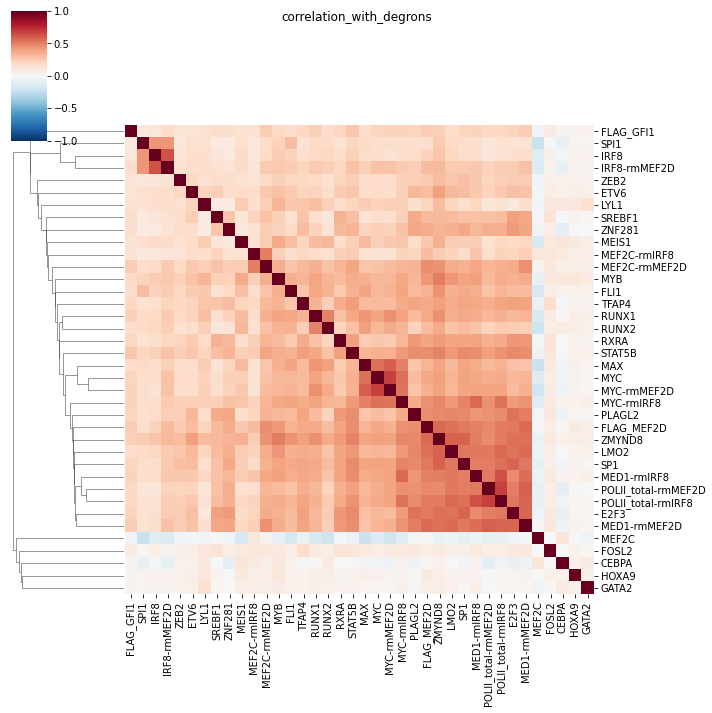

In [299]:
#correlation_withannotation
names = merged.columns[cols:annot].tolist() + merged.columns[131:].tolist()
data = pd.DataFrame(np.corrcoef(merged[names].T.astype(bool)), columns=names, index = names)
link = linkage(data)

fig = sns.clustermap(data, vmin=-1,vmax=1, figsize=(10,10), cmap='RdBu_r', row_linkage=link, col_linkage=link)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("correlation_with_degrons")
#fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/correlation_with_annotation.pdf')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/correlation_with_degrons.pdf')

plt.show()

In [300]:
overlap, correlation = chip.pairwiseOverlap(merged[names], norm=True)
enrichment, pvals = chip.enrichment(merged[names])

we will be correcting for fully similar lines/ columns by removing 1 on their last value


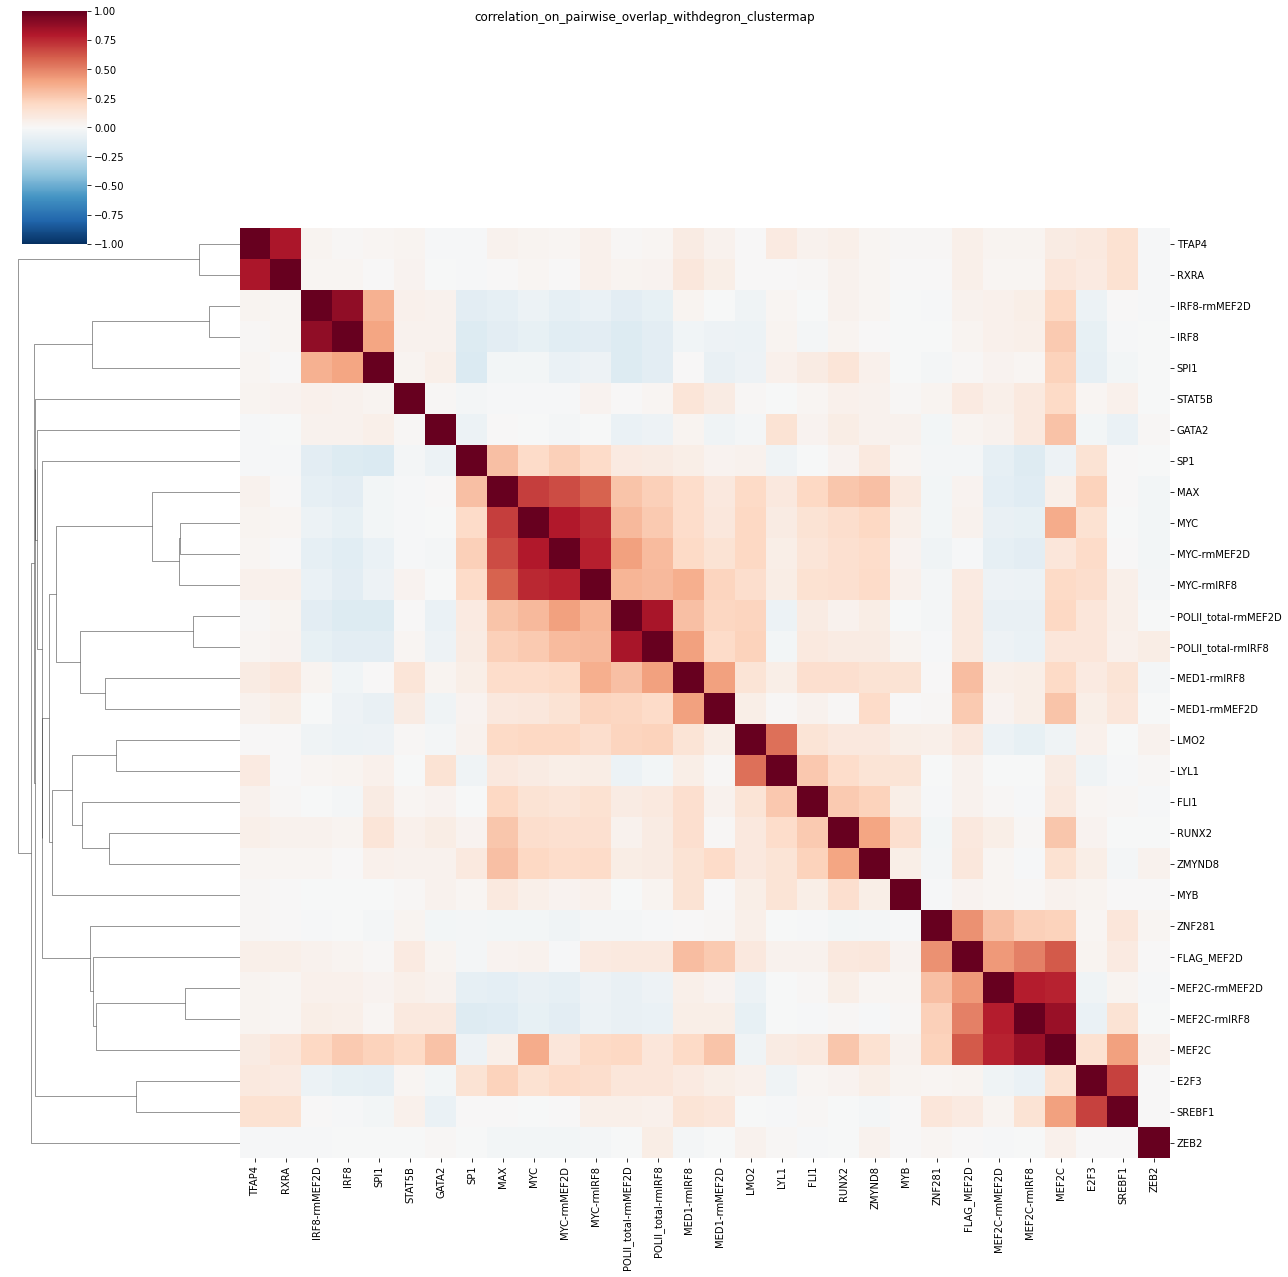

In [301]:
link = linkage(correlation, optimal_ordering=True)
fig = sns.clustermap(correlation, row_linkage=link, figsize=(18,18), vmin=-1, vmax=1, cmap='RdBu_r', col_linkage=link,)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("correlation_on_pairwise_overlap_withdegron_clustermap")
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/correlation_onoverlap_withdegron.pdf')
plt.show()

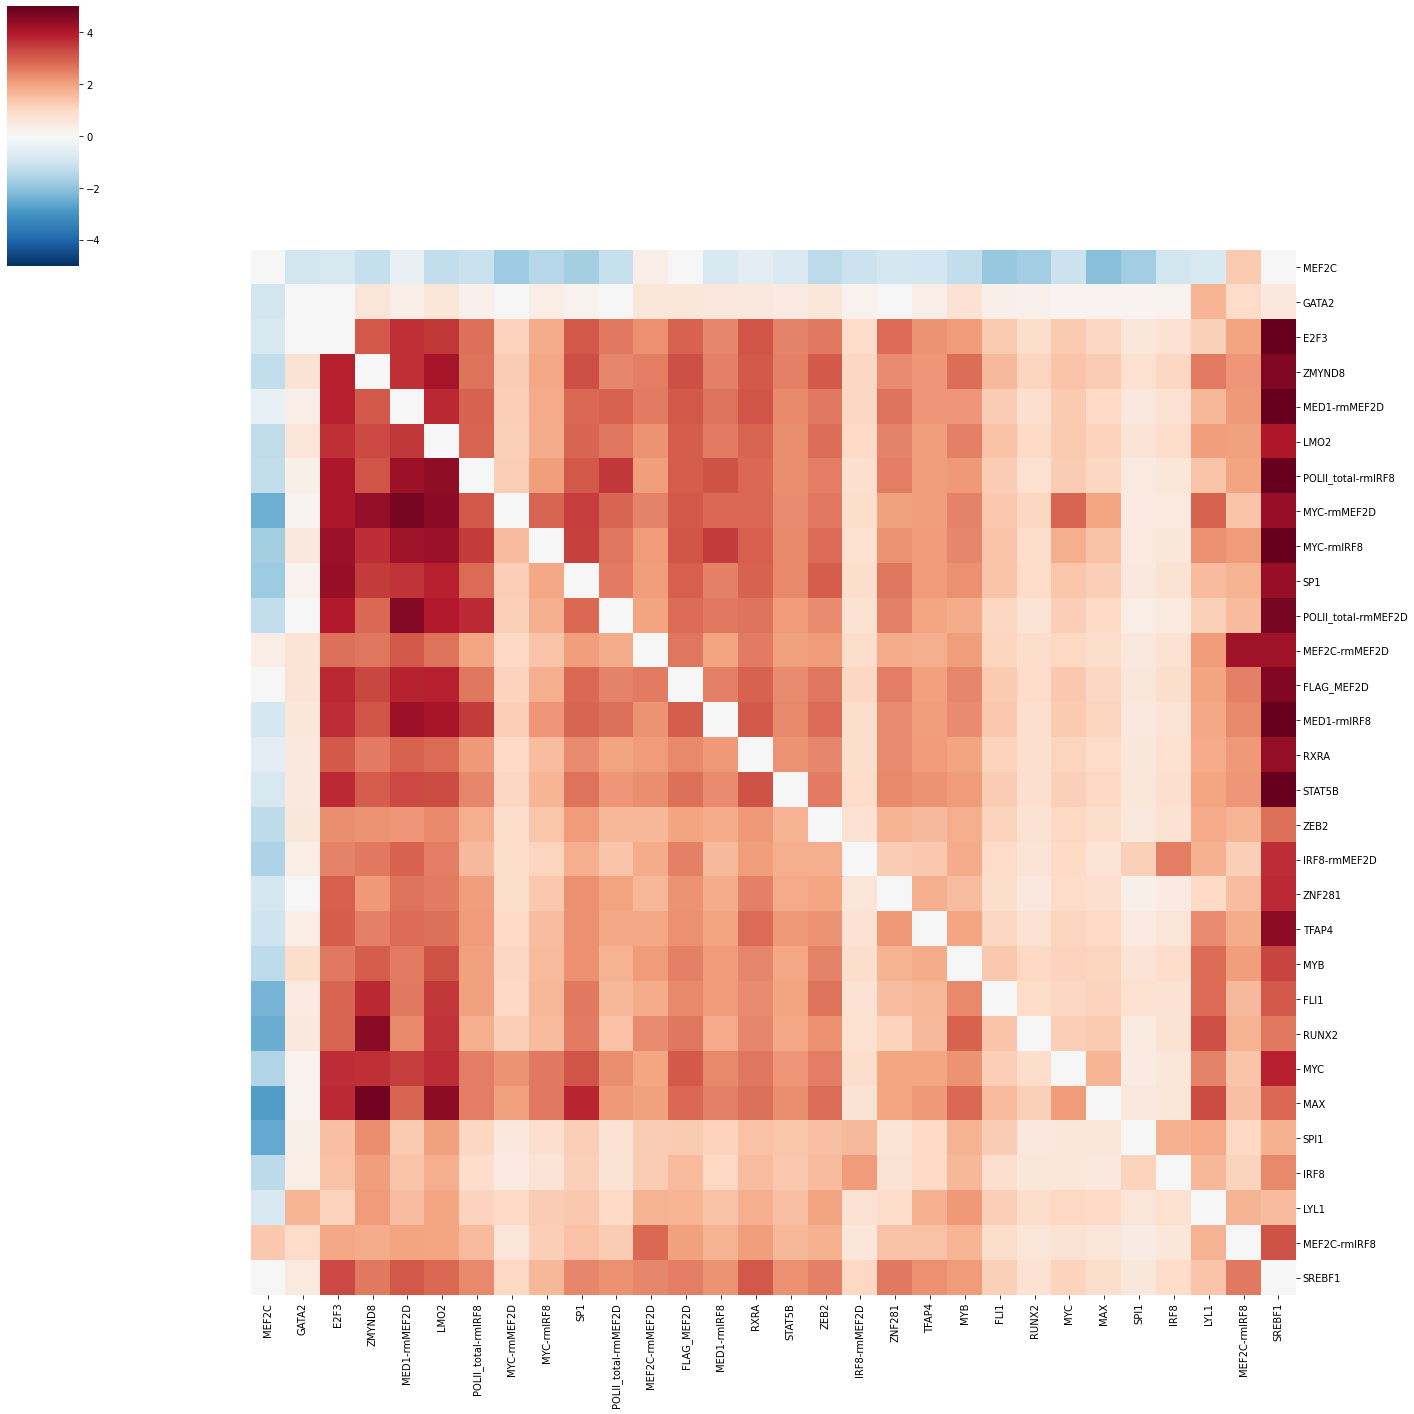

In [302]:
link = linkage(enrichment, optimal_ordering=True)
fig = sns.clustermap(enrichment,figsize=(20,20), vmin=-5,vmax=5, cmap='RdBu_r', col_linkage=link, row_linkage=link)
fig.ax_col_dendrogram.set_visible(False)
fig.ax_row_dendrogram.set_visible(False)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_clustermap_withdegron.pdf')
plt.show()

In [610]:
degrad = 123

In [611]:
maxv=4
rdb = cm.get_cmap('RdBu_r', 256)
vals = merged.columns[cols:annot]
col = enr.loc[merged.columns[degrad+cols:].tolist()].copy().T
col[col<-maxv]=-maxv
col[col>maxv]=maxv
col = col/maxv
collink = order
rowlink = linkage(enr.loc[merged.columns[cols:annot]], metric="cosine")
rowlinkMot = linkage(enr.loc[merged.columns[degrad+cols:]])
for val in merged.columns[cols+degrad:].tolist():
    col[val] =[rdb(128+int(v*128)) for v in col[val]]

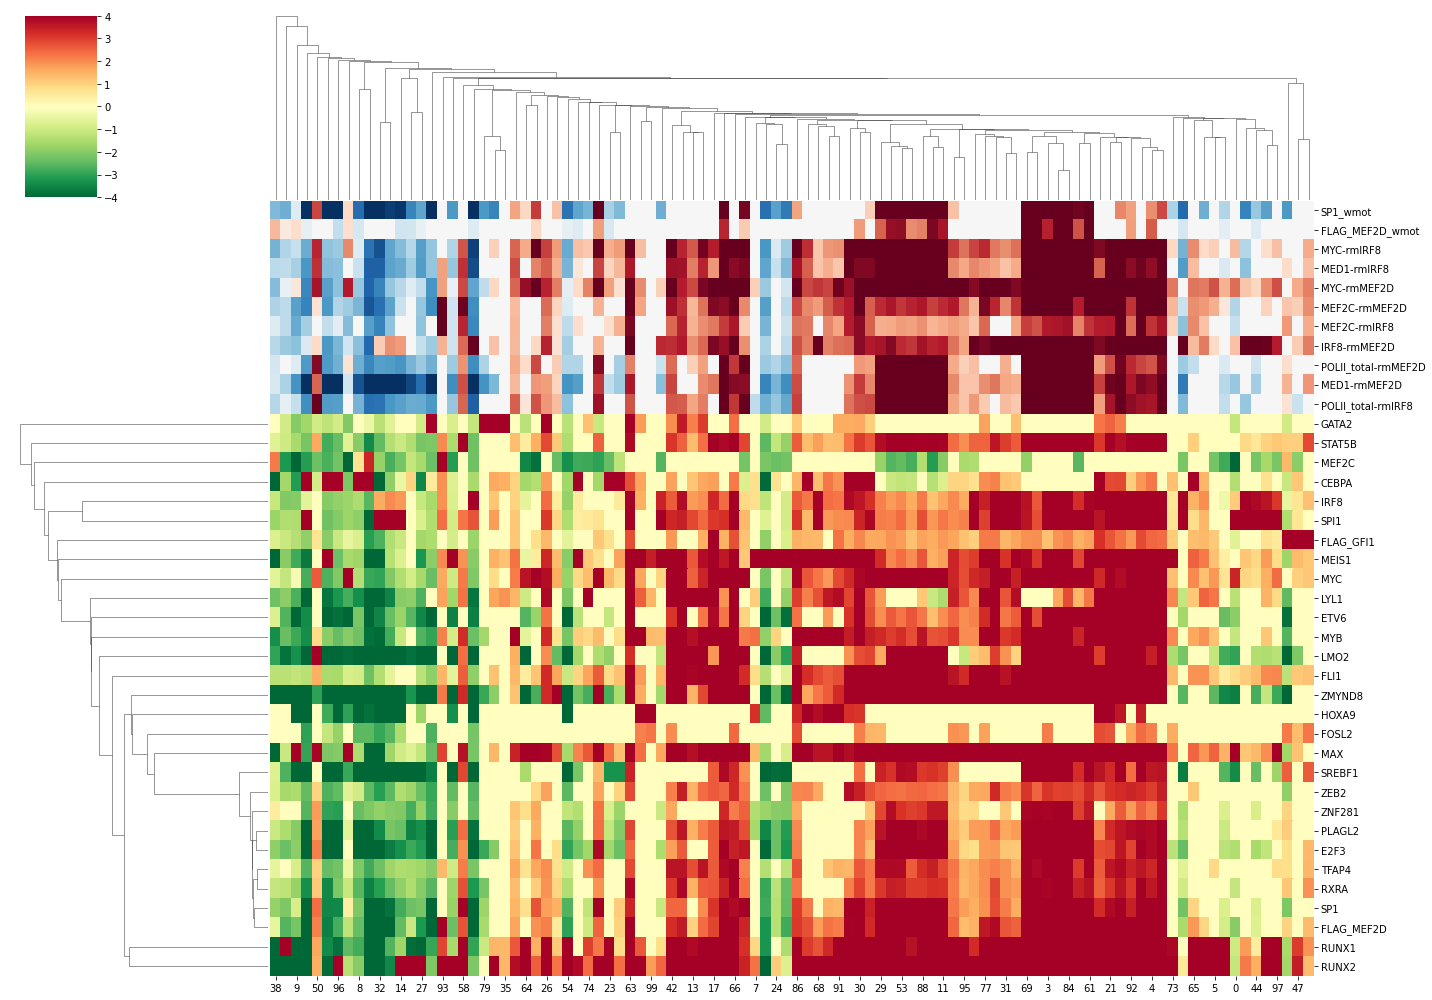

In [612]:
fig = sns.clustermap(enr.loc[merged.columns[cols:annot]], figsize=(20,14), vmax=4, vmin=-4, cmap='RdYlGn_r', col_colors=col, colors_ratio=0.02, col_linkage=collink, row_linkage=rowlink)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/motifs_and_crc_enrichment_on_clusters_'+str(n_clust[n])+'_with_degraders.pdf')
plt.show()

## QCing and motif discovering chips with MEME-chip

In [ ]:
## computing predicted motif for each TF from Chip data MEME-Chip
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast

    ! mkdir ../../data/$project/MEME_$version/
    ! cp ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed && $gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O ../temp/middle.fasta -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed -V ../temp/input_snp.vcf.gz && fold ../temp/middle.fasta -w 500 > ../../data/$project/MEME_$version/$chip.fasta

    cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && meme-chip --oc ../../data/"+project+"/MEME_"+version+"/"+chip+"/ -db ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme ../../data/"+project+"/MEME_"+version+"/"+chip+".fasta"
    ! $cmd

    ! gff2bed < ../../data/$project/MEME_$version/$chip/fimo.gff > ../../data/$project/MEME_$version/$chip.gff.bed

In [ ]:
## comparing with the litterature using MEME.tomtom


## Assigning genes

### based on closest expressed gene

In [ ]:
chiphelper.AssignToClosestExpressed()

In [ ]:
### recompute cobinding based on this.

In [ ]:
## redo the plots. do we get better plots?/correlations?...

### based on the ABC model

![](images/ABCtitle.png)

They tested a new model based on and validated by CRISPRi-FlowFISH which is basically able to find enhancer mapping to genes. 
They used it to compute their model's Accuracy and found a 70% accuracy compared to less than 50% for closest expressed gene. 

Way to integrate our HiC data (need ATAC-seq like data as well, but openly available) 


![](images/ABCmodel.png)

In [413]:
# ATAC bam file
! mkdir ../../data/ATACseq/
! gsutil cp gs://amlproject/ATAC/MV411/mergedLibrary/ATAC_MV411_R3.mLb.clN.sorted.ba* ../../data/ATACseq/
    
# ATAC broad peaks (just in case)
! gsutil cp gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_MV411_R3*.broadPeak ../../data/ATACseq/

# INPUT bam
!gsutil cp "gs://amlproject/Chip/cobinding/bwa/mergedLibrary/mp845-MV411-INPUT_R1.mLb.clN.sorted.ba*" ../../data/ref/

# H3K27ac Bam
!gsutil cp gs://amlproject/Chip/cobinding/bwa/mergedLibrary/mp702* ../../data/bams/

# Making expression file
!wget https://ndownloader.figshare.com/files/26261476
!mv 26261476 ../../data/expression.csv
reads = pd.read_csv('../../data/expression.csv', index_col=0)
reads = reads.loc['ACH-000045']
reads.index = [i.split(' (')[0] for i in reads.index]
reads.to_csv('../../data/MV411_expression.tsv',sep='\t', header=False)

## download HIC:
! wget ftp://ftp.broadinstitute.org/outgoing/lincRNA/average_hic/average_hic.v2.191020.tar.gz
! mkdir ../../data/hic
! mv average_hic.v2.191020.tar.gz ../../data/hic/
! tar -xf ../../data/hic/average_hic.v2.191020.tar.gz
! mv "chr"* ../../data/hic/


Copying gs://amlproject/ATAC/MV411/mergedLibrary/ATAC_MV411_R3.mLb.clN.sorted.bam...
- [1 files][  1.7 GiB/  1.7 GiB]   80.6 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      
CommandException: No URLs matched: gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_MV411_R3*.broadPeak


In [531]:
! tar -xf ../../data/hic/average_hic.v2.191020.tar.gz
! mv "chr"* ../../data/hic/

In [430]:
! macs3 callpeak -B -t ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam -c ../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam --nomodel -n ATAC_R3 --outdir ../../data/ATACseq/ -f BAMPE --call-summits 

INFO  @ Thu, 01 Apr 2021 15:22:58: 
# Command line: callpeak -B -t ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam -c ../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam --nomodel -n ATAC_R3 --outdir ../../data/ATACseq/ -f BAMPE --call-summits
# ARGUMENTS LIST:
# name = ATAC_R3
# format = BAMPE
# ChIP-seq file = ['../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam']
# control file = ['../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is on
# Searching for subpeak summits is on
 
INFO  @ Thu, 01 Apr 2021 15:22:58: #1 read fragment files...

INFO  @ Thu, 01 Apr 2021 15:51:24: #4 Write output xls file... ../../data/ATACseq/ATAC_R3_peaks.xls 
INFO  @ Thu, 01 Apr 2021 15:51:24: #4 Write peak in narrowPeak format file... ../../data/ATACseq/ATAC_R3_peaks.narrowPeak 
INFO  @ Thu, 01 Apr 2021 15:51:25: #4 Write summits bed file... ../../data/ATACseq/ATAC_R3_summits.bed 
INFO  @ Thu, 01 Apr 2021 15:51:25: Done! 


In [438]:
import sys 
sys.path.append('../src/ABC-Enhancer-Gene-Prediction/src')
from peaks import *

In [474]:
os.makedirs(os.path.join("../results/ABC_output/Peaks/"), exist_ok=True)
make_candidate_regions_from_peaks(macs_peaks = "../../data/ATACseq/ATAC_R3_peaks.narrowPeak", 
                                accessibility_file = "../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam", 
                                genome_sizes = "../../genepy/data/hg38.chrom.sizes.txt", 
                                regions_blacklist = "../data/"+project+"/hg38-blacklist.v2.bed",
                                n_enhancers = 25000, 
                                peak_extend = 250, 
                                minPeakWidth=500,
                                regions_whitelist="",
                                outdir = "../results/ABC_output/Peaks/")

Running: bedtools sort -i ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeakATAC_MV411_R3.mLb.clN.sorted.bam.Counts.bed -faidx ../../genepy/data/hg38.chrom.sizes.txt | bedtools merge -i stdin -c 4 -o max | sort -nr -k 4 | head -n 25000 |bedtools intersect -b stdin -a ../../data/ATACseq/ATAC_R3_peaks.narrowPeak -wa |bedtools slop -i stdin -b 250 -g ../../genepy/data/hg38.chrom.sizes.txt |awk '{ l=$3-$2; if (l < 500) { $2 = $2 - int((500-l)/2); $3 = $3 + int((500-l)/2) } print $1 "\t" $2 "\t" $3}' |bedtools sort -i stdin -faidx ../../genepy/data/hg38.chrom.sizes.txt |bedtools merge -i stdin | bedtools intersect -v -wa -a stdin -b ../data/Cobinding_ChIP/hg38-blacklist.v2.bed | cut -f 1-3 | bedtools sort -i stdin -faidx ../../genepy/data/hg38.chrom.sizes.txt | bedtools merge -i stdin > ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed


b''

In [481]:
ls ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed

../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed


In [508]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/run.neighborhoods.py \
--candidate_enhancer_regions ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed \
--genes ../src/ABC-Enhancer-Gene-Prediction/reference/RefSeqCurated.170308.bed.CollapsedGeneBounds.bed \
--H3K27ac ../../data/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam \
--ATAC ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam \
--expression_table ../../data/MV411_expression.tsv \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--ubiquitously_expressed_genes ../src/ABC-Enhancer-Gene-Prediction/reference/UbiquitouslyExpressedGenesHG19.txt \
--cellType M411 \
--outdir ../results/ABC_output/ 

Namespace(ATAC='../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam', DHS='', H3K27ac='../../data/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam', candidate_enhancer_regions='../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed', cellType='M411', chrom_sizes='../../genepy/data/hg38.chrom.sizes.txt', default_accessibility_feature=None, enhancer_class_override=None, expression_table='../../data/MV411_expression.tsv', gene_name_annotations='symbol', genes='../src/ABC-Enhancer-Gene-Prediction/reference/RefSeqCurated.170308.bed.CollapsedGeneBounds.bed', genes_for_class_assignment=None, outdir='../results/ABC_output/', primary_gene_identifier='symbol', qnorm=None, skip_gene_counts=False, skip_rpkm_quantile=False, supplementary_features=None, tss_slop_for_class_assignment=500, ubiquitously_expressed_genes='../src/ABC-Enhancer-Gene-Prediction/reference/UbiquitouslyExpressedGenesHG19.txt', use_secondary_counting_method=False)
Using gene expression from files: ['../../d

In [532]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/predict.py \
--enhancers ../results/ABC_output/EnhancerList.txt \
--genes ../results/ABC_output/GeneList.txt \
--HiCdir ../../data/hic/ \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--hic_resolution 5000 \
--scale_hic_using_powerlaw \
--threshold .02 \
--cellType MV411 \
--outdir ../results/ABC_output/ \
--make_all_putative

reading genes
reading enhancers
Making predictions for chromosome: chr16
Making putative predictions table...
Using: ../../data/hic/chr16/chr16.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 23.720621824264526
HiC Matrix has row sums of 0.9999994815362977, continuing without making doubly stochastic
HiC has 10938120 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 11.120196342468262
HiC added to predictions table. Elapsed time: 3.3977084159851074
HiC Complete
Completed chromosome: chr16. Elapsed time: 44.04684805870056 

Making predictions for chromosome: chr21
Making putative predictions table...
Using: ../../data/hic/chr21/chr21.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 7.253567934036255
HiC Matrix has row sums of 0.9999994247035542, continuing without making doubly stochastic
HiC has 5288227 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 3.6769890785217285
HiC added to predictions table. Elapsed tim

HiC has 20725658 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 24.01411271095276
HiC added to predictions table. Elapsed time: 8.97029185295105
HiC Complete
Completed chromosome: chr11. Elapsed time: 100.45883822441101 

Making predictions for chromosome: chr8
Making putative predictions table...
Using: ../../data/hic/chr8/chr8.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 70.73034358024597
HiC Matrix has row sums of 0.9999996189976109, continuing without making doubly stochastic
HiC has 23599748 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 30.05237317085266
HiC added to predictions table. Elapsed time: 7.960023641586304
HiC Complete
Completed chromosome: chr8. Elapsed time: 123.42189359664917 

Making predictions for chromosome: chr4
Making putative predictions table...
Using: ../../data/hic/chr4/chr4.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 85.91648864746094
HiC Matrix has row sums of 1.000000

In [537]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/getVariantOverlap.py \
--all_putative ../results/ABC_output/EnhancerPredictionsAllPutative.txt.gz \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--outdir ../results/ABC_output/


gzip: stdout: Broken pipe
Done.


In [ ]:
thresh = 0.02

In [552]:
allpred = pd.read_csv('../results/ABC_output/EnhancerPredictionsAllPutative.txt.gz', sep='\t')

In [556]:
merged

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,FLAG_GFI1,CEBPA,...,FLAG_MEF2D_wmot,MYC-rmIRF8,MED1-rmIRF8,MYC-rmMEF2D,MEF2C-rmMEF2D,MEF2C-rmIRF8,IRF8-rmMEF2D,POLII_total-rmMEF2D,MED1-rmMEF2D,POLII_total-rmIRF8
0,chr1,9936,10300,0,10.264422,31242.919925,20942.926956,107,0.00000,0.000000,...,NaN,0.00000,0.00000,0.00000,3.28590,0.0,0.00000,0.00000,0.00000,3.08488
1,chr1,180636,182055,3,6.703357,106618.940101,24609.011579,144,0.00000,0.000000,...,NaN,3.62244,0.00000,3.85273,3.32037,0.0,4.20929,3.70559,0.00000,3.30538
2,chr1,183251,183855,4,3.734692,20.225199,5.923574,67,4.62681,0.000000,...,NaN,3.62781,2.96802,2.87602,3.22063,0.0,2.31121,5.04909,3.28909,4.94178
3,chr1,184152,184594,5,4.397137,12.820100,9.812510,318,4.62681,0.000000,...,NaN,3.62781,2.96802,2.87602,3.22063,0.0,2.31121,5.04909,0.00000,4.94178
4,chr1,261106,262752,7,4.597080,293.448414,212.104111,283,0.00000,0.000000,...,NaN,0.00000,0.00000,0.00000,0.00000,0.0,13.46808,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142965,chrY,56850335,56851130,383692,3.706216,664.387135,212.008805,128,0.00000,3.754963,...,NaN,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142966,chrY,56858996,56861172,383696,1.588705,5.191290,2.496940,2349,0.00000,0.000000,...,NaN,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142967,chrY,56863301,56866023,383697,1.902315,7.892270,4.814480,6053,0.00000,0.000000,...,NaN,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
142968,chrY,56872906,56873928,383699,1.999365,4.855900,2.227570,240,0.00000,0.000000,...,NaN,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000


In [559]:
allpred = allpred.sort_values(by=['chr','start','end','TargetGeneTSS']).rename(columns={'chr':'chrom'}).reset_index(drop=True)

KeyError: 'chr'

In [ ]:
putInBed(merged, allpred

In [561]:
enhancers = pd.read_csv('../results/ABC_output/EnhancerList.bed', sep='\t')

In [562]:
enhancers.sort_values(by='')

,chr1,826663,828253,intergenic|chr1:826663-828253
0,chr1,837911,839072,intergenic|chr1:837911-839072
1,chr1,904212,905090,genic|chr1:904212-905090
2,chr1,906038,907534,genic|chr1:906038-907534
3,chr1,958645,960411,genic|chr1:958645-960411
4,chr1,965645,967655,genic|chr1:965645-967655
...,...,...,...,...
24320,chrY,19076814,19078391,intergenic|chrY:19076814-19078391
24321,chrY,19566480,19568202,intergenic|chrY:19566480-19568202
24322,chrY,19846777,19847652,intergenic|chrY:19846777-19847652
24323,chrY,20575220,20576253,intergenic|chrY:20575220-20576253


In [563]:
allpred

,chrom,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact_reference,hic_contact,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
0,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,NOC2L,894679,6.227664,0.571508,...,0.012873,0.006239,0.006239,0.001229,0.007468,0.042571,0.030615,0.073380,0.037160,MV411
1,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,KLHL17,895966,4.570463,0.061685,...,0.012663,0.005484,0.005484,0.001229,0.006713,0.038267,0.025929,0.072179,0.035706,MV411
2,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,ISG15,948846,4.857483,0.701337,...,0.007698,0.002575,0.002575,0.001229,0.003804,0.021686,0.013744,0.043881,0.017480,MV411
3,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,AGRN,955502,4.911212,0.920712,...,0.007349,0.002560,0.002560,0.001229,0.003789,0.021599,0.010490,0.041889,0.013555,MV411
4,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,C1orf159,1051736,3.864929,0.335438,...,0.004513,0.001305,0.001305,0.001229,0.002534,0.014443,0.007075,0.025723,0.007777,MV411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731091,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,BRCC3,154299694,3.984589,0.448510,...,0.000819,0.000000,0.000000,0.000819,0.000819,0.001797,0.001912,0.001797,0.000969,MV411
1731092,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,VBP1,154444700,5.280214,0.933135,...,0.000890,0.000000,0.000000,0.000890,0.000890,0.001953,0.001947,0.001953,0.000908,MV411
1731093,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,TMLHE,154842622,2.226509,0.182661,...,0.001177,0.000000,0.000000,0.001177,0.001177,0.002582,0.003473,0.002582,0.002813,MV411
1731094,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,VAMP7,155110942,4.679762,0.043978,...,0.001521,0.000000,0.000000,0.001229,0.001229,0.002696,0.004180,0.003337,0.004059,MV411


In [543]:
ls -ahl ../results/ABC_output/

total 187M
drwxr-xr-x  3 jeremie jeremie 4.0K Apr  2 21:58 ./
drwxr-xr-x 24 jeremie jeremie 4.0K Apr  2 15:42 ../
-rw-r--r--  1 jeremie jeremie 1.4M Apr  2 18:54 EnhancerList.bed
-rw-r--r--  1 jeremie jeremie 7.0M Apr  2 18:54 EnhancerList.txt
-rw-r--r--  1 jeremie jeremie 6.3M Apr  7 18:16 EnhancerPredictionsAllPutative.ForVariantOverlap.shrunk150bp.txt.gz
-rw-r--r--  1 jeremie jeremie 6.1M Apr  7 18:16 EnhancerPredictionsAllPutative.ForVariantOverlap.shrunk150bp.txt.gz.tmp
-rw-r--r--  1 jeremie jeremie  36M Apr  2 21:57 EnhancerPredictionsAllPutativeNonExpressedGenes.txt.gz
-rw-r--r--  1 jeremie jeremie  61M Apr  2 21:56 EnhancerPredictionsAllPutative.txt.gz
-rw-r--r--  1 jeremie jeremie  14M Apr  2 21:55 EnhancerPredictions.bedpe
-rw-r--r--  1 jeremie jeremie  29M Apr  2 21:55 EnhancerPredictionsFull.txt
-rw-r--r--  1 jeremie jeremie  11M Apr  2 21:55 EnhancerPredictions.txt
-rw-r--r--  1 jeremie jeremie 663K Apr  2 18:54 Enhancers.ATAC.ATAC_MV411_R3.mLb.clN.sorted.bam.CountReads.be

In [ ]:
### recompute cobinding based on this.

In [ ]:
### redo the plots. do we get better looking plots?

In [ ]:
### compare presence of CTCF and transcription of linked RNA

## Predict

In [ ]:
## enrichment at the gene set level

In [ ]:
## are our cobinding clusters enriched in some sets of genes / CRC? 

In [ ]:
## make a linear model to with marks and cobinding data + motifs and TFs+cobinding motifs + expression of cobound proteins + expression , can we predict expression/dependenccy?

In [ ]:
## can we predict better for some set of genes / CRCs?

In [ ]:
## do the same on closest expressed gene

In [ ]:
## do this prediction on each enhancer.what is the best predicting enhancer? do that correlate with ABC model data?

In [ ]:
## do we get, for some gene, better single enhancer prediction?

In [ ]:
## what are the gene sets enriched in each clusters?? (based on TF cobinding or based on TF cobinding + )

## RNP data

In [ ]:
## can we predict RNP data (setting this TF to zero and lookingg at expected RNA change)
## do we see genes with opposite effects? 

In [ ]:
## if we add RNP data, can we increase our model's prediction? (we have expression change and we set all RNPed-TF values to 0) 

In [ ]:
### to predict remaining X% RNA expression
### to predict remaining X TFs RNP
### to predict regular RNA expression

In [ ]:
## same thing with filtering base on motif presence (actual DNA binding)
## same thing with closest expressed gene

In [ ]:
## Do on all cell lines

In [ ]:
## repeat the process across all samples with H3K27ac+RNAseq data we have.

In [ ]:
## call mutations from H3k27ac data

In [ ]:
## MEME analysis of likely bound TFs, except if TF is not expressed

In [ ]:
## compute enrichments

In [ ]:
## from same gene assignements, as found on the general consensus peak set, can we find good dependency/expression prediction

### Compare data with other labs (H3K27, HiC..)

we need to redo everything for similar normal cell type, getting TFs based on the CRC (find it with CRCmapper or on litterature)